In [45]:
#================================================================
#Statistical Analysis Dataframe Creation
#================================================================

In [46]:
#Importing Packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import preprocessing as pre
import tropycal.tracks as tracks
import tropycal as tc
import datetime
import scipy.stats as stats
import xarray as xr
import geopandas as gpd
import netCDF4

from scipy.stats import poisson
from scipy.stats import pearsonr
from geopy.distance import distance
from geopy import Point
from geopy import distance


pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)

In [47]:
#File paths

hemi = 'SH'
basin = 'si'

#observational data
obs_file_path = "D:\Masters_Thesis\Data_For_Analysis\observations\ibtracs.SI.list.v04r00.csv"

#control_1950
control_file_path = "D:\Masters_Thesis\Data_For_Analysis\control-1950\EC-Earth_Consortium\EC-Earth3p-HR\\r1i1p2f1\TC-SH_TRACK_EC-Earth3P-HR_control-1950_r1i1p2f1_gr_19500101-20491231.nc"

#highres_future
future_file_path = "D:\Masters_Thesis\Data_For_Analysis\highres-future\EC-Earth_Consortium\EC-Earth3p-HR\\r1i1p2f1\TC-SH_TRACK_EC-Earth3P-HR_highres-future_r1i1p2f1_gr_20150101-20501231.nc"


In [48]:
test=xr.open_dataset(control_file_path)
test

<xarray.Dataset>
Dimensions:              (tracks: 4988, record: 299705, plev: 6)
Coordinates:
  * plev                 (plev) int32 925 850 700 600 500 250
Dimensions without coordinates: tracks, record
Data variables: (12/36)
    FIRST_PT             (tracks) int32 ...
    NUM_PTS              (tracks) int32 ...
    TRACK_ID             (tracks) int32 ...
    index                (record) int32 ...
    lat                  (record) float32 ...
    lat_psl              (record) float32 ...
    ...                   ...
    rv850_T63            (record) float32 ...
    sfcWind              (record) float32 ...
    time                 (record) datetime64[ns] ...
    vortmean_T63         (record) float32 ...
    warm_core_indicator  (record) int32 ...
    ws925                (record) float32 ...
Attributes: (12/56)
    activity_id:               HighResMIP
    branch_method:             none provided
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     0.0
    cmor_version:              3.3.2
    ...                        ...
    nco_openmp_thread_number:  1
    further_info_url:          https://furtherinfo.es-doc.org/CMIP6.EC-Earth-...
    CMIP6_MODEL:               CMIP6.HighResMIP.EC-Earth-Consortium.EC-Earth3...
    CMIP6_REFERENCE:           EC-Earth Consortium (EC-Earth) (2018). EC-Eart...
    CMIP6_DOI:                 https://doi.org/10.22033/ESGF/CMIP6.
    version:                   v20181119

In [49]:
from global_land_mask import is_ocean

In [50]:
def normalize_longitude(longitude):
        """
        Normalize the longitude value to be within -180 and 180 degrees.
        """
        while longitude > 180:
            longitude -= 360
        while longitude < -180:
            longitude += 360
        return longitude

def read_storms_filtered(file_path, hemi, basin):
    """
    For a given file path, read the storms from the file.
    """

    # Read the netcdf file
    storms = list(pre.load_cmor(file_path))

    # Check the metadata to discover which algorithm this is, and hence
    # what feature variable is tracked
    with netCDF4.Dataset(file_path, 'r') as nc:
        track_algorithm = nc.getncattr('algorithm')
        if track_algorithm == 'TRACK':
            track_extra = nc.getncattr('algorithm_extra')
            if track_extra == 'T63avg':
                feature_variable = 'vortmean_T63'
            else:
                feature_variable = 'rv850_T42'
        elif track_algorithm == 'TempestExtremes':
            feature_variable = 'psl'
        else:
            raise Exception('Unrecognised algorithm in netcdf file '+file_path)

    if hemi.lower() == 'nh':
        months = pre.months_nh
        lat_min, lat_max, lon_min, lon_max = pre.basin_bounds[basin]
    elif hemi.lower() == 'sh':
        months = pre.months_sh
        lat_min, lat_max, lon_min, lon_max = pre.basin_bounds[basin]
    else:
        raise ValueError('Invalid hemisphere argument. Must be "NH" or "SH"')

    # Filter out storms that do not meet the specified criteria
    filtered_storms = []
    storm_track_points = []  # List to store the storm track points
    for storm in storms:
        # Check if the storm lasted longer than 2 days, check that the 250 hpa and 850 hpa variables are not none, check the difference between 250 hpa and 850 hpa is greater than 0, indicating a warm core
        if storm._storm_vmax_in_basin(basin) and storm.lifetime >= 2 and \
            storm.t63_850_250_diff_max is not None and storm.t63_850_250_diff_max > 0:
            # Normalize the longitude of the first storm track point
            lon = normalize_longitude(storm.obs[0].lon)

           # Check if the normalized longitude and latitude are over the ocean
            if lon <= 180:  # Ensure the longitude is within the valid range
                if is_ocean(storm.obs[0].lat, lon):
                    filtered_storms.append(storm)
                    storm_track_points.extend(storm.obs)

    return filtered_storms, feature_variable, months, storm_track_points

In [51]:
control_filtered_storms, feature_variable, months, storm_track_points = read_storms_filtered(control_file_path,hemi,basin)
print(control_filtered_storms)

fh type <class 'str'>
fname  D:\Masters_Thesis\Data_For_Analysis\control-1950\EC-Earth_Consortium\EC-Earth3p-HR\r1i1p2f1\TC-SH_TRACK_EC-Earth3P-HR_control-1950_r1i1p2f1_gr_19500101-20491231.nc
[<preprocessing.Storm object at 0x00000184D0A48670>, <preprocessing.Storm object at 0x00000184D0A4CF40>, <preprocessing.Storm object at 0x00000184D0A4CD00>, <preprocessing.Storm object at 0x00000184D0A4C8B0>, <preprocessing.Storm object at 0x00000184D0A4C5E0>, <preprocessing.Storm object at 0x00000184D0A4C8E0>, <preprocessing.Storm object at 0x00000184D74BA100>, <preprocessing.Storm object at 0x00000184D74BAAF0>, <preprocessing.Storm object at 0x00000184D0A43400>, <preprocessing.Storm object at 0x00000184D0A431F0>, <preprocessing.Storm object at 0x00000184D0A43220>, <preprocessing.Storm object at 0x00000184D0A430A0>, <preprocessing.Storm object at 0x00000184D0A43280>, <preprocessing.Storm object at 0x00000184D0A43C70>, <preprocessing.Storm object at 0x00000184D0A43D00>, <preprocessing.Storm objec

In [52]:
future_filtered_storms, feature_variable, months, storm_track_points = read_storms_filtered(future_file_path,hemi,basin)

fh type <class 'str'>
fname  D:\Masters_Thesis\Data_For_Analysis\highres-future\EC-Earth_Consortium\EC-Earth3p-HR\r1i1p2f1\TC-SH_TRACK_EC-Earth3P-HR_highres-future_r1i1p2f1_gr_20150101-20501231.nc


In [53]:
#Load data from files

hemi = 'SH'
basin = 'si'

#observational data
ibtracs = tracks.TrackDataset(basin='south_indian', source='ibtracs', ibtracs_url=obs_file_path, ibtracs_mode="wmo")


#control_1950
control_storms, feature_variable, months, storm_track_points = read_storms_filtered(control_file_path, hemi, basin)
print(control_storms)

#highres_future
future_storms, feature_variable, months, storm_track_points = read_storms_filtered(future_file_path, hemi,basin)


--> Starting to read in ibtracs data
--> Completed reading in ibtracs data (7.92 seconds)
fh type <class 'str'>
fname  D:\Masters_Thesis\Data_For_Analysis\control-1950\EC-Earth_Consortium\EC-Earth3p-HR\r1i1p2f1\TC-SH_TRACK_EC-Earth3P-HR_control-1950_r1i1p2f1_gr_19500101-20491231.nc
[<preprocessing.Storm object at 0x00000184F5727AF0>, <preprocessing.Storm object at 0x00000184F2EEB700>, <preprocessing.Storm object at 0x00000184F2EEB640>, <preprocessing.Storm object at 0x00000184F2EEB2B0>, <preprocessing.Storm object at 0x00000184F2702D00>, <preprocessing.Storm object at 0x00000184F0BCDF70>, <preprocessing.Storm object at 0x00000184F0BCD8B0>, <preprocessing.Storm object at 0x00000184F0BCDAC0>, <preprocessing.Storm object at 0x00000184E9762DC0>, <preprocessing.Storm object at 0x00000184E9762D90>, <preprocessing.Storm object at 0x00000184E97620A0>, <preprocessing.Storm object at 0x00000184E9762040>, <preprocessing.Storm object at 0x00000184E9762220>, <preprocessing.Storm object at 0x0000018

In [54]:
def create_storm_dataframe(storms):
    # Create an empty dictionary to hold the storm data
    storm_data = { "lat": [], "lon": []}

    # Loop over the filtered storms and add the relevant information to the dictionary
    for storm in storms:
        
        # Iterate over the storm observations
        for obs in storm.obs:
            # Access the latitude and longitude values using appropriate attributes or methods
            latitude = obs.lat
            longitude = obs.lon

            storm_data["lat"].append(latitude)
            storm_data["lon"].append(longitude)


    # Create a DataFrame from the storm data dictionary
    storm_df = pd.DataFrame(storm_data)
    
    return storm_df

In [55]:
#Reading in IBTRaCS data for SWIO region and filter by time period
ibtracs_filter_df = ibtracs.filter_storms(year_range=(1980,2015), date_range=('7/1','6/30'), return_keys=False)


#Reorder columns of filtered dataframe
ibtracs_filter_df.reindex(columns=['season', 'stormid', 'vmax', 'mslp', 'type','lat', 'lon', 'date', 'ace'])
print(ibtracs_filter_df)


#Adjust date format
ibtracs_filter_df['date'] = pd.to_datetime(ibtracs_filter_df['date'])


bystorm = (ibtracs_filter_df.groupby(['season', 'stormid'], as_index=False)
         .agg(start_date=('date', lambda s: s.min().normalize()),
              end_date=('date', lambda s: s.max().normalize()),
              vmax_max=('vmax', 'max')
             )
         .assign(days=lambda d: d['end_date'].sub(d['start_date']).dt.days,
                 start_year=lambda d: d['start_date'].dt.year,
                 end_year=lambda d: d['end_date'].dt.year)
       )
bystorm = bystorm.rename(columns={'vmax_max': 'vmax'})


print(bystorm)



# Rename columns
df1 = bystorm.rename(columns={'days': 'duration'})

#convert knots to m/s
df1['vmax'] = df1['vmax'] * 0.514444

# Drop the start_year and end_year columns
df1 = df1.drop(['start_year', 'end_year'], axis=1)


       vmax    mslp type      lat      lon                date  season  \
0        32  1000.0   TD -14.0000  80.0000 1980-01-02 00:00:00    1980   
1        28  1005.0   TD -11.0000  59.0000 1980-01-05 06:00:00    1980   
2        22  1005.0   TD -13.6000  66.4000 1980-01-08 12:00:00    1980   
3        32  1000.0   TD -20.3000  51.0000 1980-01-12 06:00:00    1980   
4        32  1000.0   TD -26.0000  47.2000 1980-01-11 06:00:00    1980   
...     ...     ...  ...      ...      ...                 ...     ...   
11804    28  1008.0   TD -27.7000  65.3000 2015-12-15 12:00:00    2016   
11805    22  1010.0   TD -28.1500  65.4000 2015-12-15 18:00:00    2016   
11806    22  1011.0   TD -28.7500  65.7000 2015-12-16 00:00:00    2016   
11807    22  1011.0   TD -29.5571  66.5429 2015-12-16 06:00:00    2016   
11808    22  1012.0   TD -30.4000  67.9200 2015-12-16 12:00:00    2016   

             stormid  ace  
0      1980002S15081  0.0  
1      1980005S11059  0.0  
2      1980009S14066  0.0  

In [56]:

# Get the year of the start_date
df1['year'] = df1['start_date'].dt.year

# Define function to create season range column
def set_season(row):
    if row['start_date'].month >= 10:
        return row['year']
    else:
        return row['year'] - 1


# Apply the function to each row to create a new column
df1['season'] = df1.apply(set_season, axis=1)


# Drop the first four rows of the dataframe
df1 = df1.drop([0, 1, 2, 3, 4, 5, 6, 7])

# Drop the last two rows of the dataframe
df1 = df1.drop(df1.tail(2).index)

#Drop the year column
df1.drop(['year'], axis=1, inplace=True)

print(df1)



     season        stormid start_date   end_date       vmax  duration
8      1980  1980308S05102 1980-11-03 1980-11-10  61.733280         7
9      1980  1980348S11116 1980-12-13 1980-12-22  64.305500         9
10     1980  1981094S06094 1981-04-05 1981-04-15  55.045508        10
11     1980  1981142S08091 1981-05-24 1981-05-30  37.554412         6
12     1981  1981306S03096 1981-11-13 1981-11-20  30.866640         7
..      ...            ...        ...        ...        ...       ...
362    2014  2015036S20038 2015-02-05 2015-02-11  31.895528         6
363    2014  2015050S11094 2015-02-20 2015-03-01  28.294420         9
364    2014  2015064S14052 2015-03-05 2015-03-11  25.722200         6
365    2014  2015092S18074 2015-04-02 2015-04-17  43.727740        15
366    2014  2015094S10087 2015-04-04 2015-04-08  55.045508         4

[359 rows x 6 columns]


In [57]:
import geopandas as gpd
from shapely.geometry import box

import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import nearest_points
from rtree import index
from scipy.spatial import cKDTree

import numpy as np
from scipy.spatial import cKDTree

In [58]:
def create_storm_track_frequency(storms):
    # Create an empty list to hold the storm data
    storm_data = []

    # Loop over the filtered storms and add the relevant information to the list
    for storm in storms:
        # Determine the start year of the storm
        start_year = storm.genesis_date.year
        # Determine the start month of the storm
        start_month = storm.genesis_date.month
        # Determine the end year of the storm
        end_year = storm.lysis_date.year
        # Determine the end month of the storm
        end_month = storm.lysis_date.month

        # Determine the season
        if start_month >= 10 or start_month < 6:
            season = start_year
        else:
            season = start_year - 1

        lat = [ob.lat for ob in storm.obs]
        lon = [ob.lon for ob in storm.obs]

        # Loop over the latitude and longitude lists and create a row for each
        for i in range(len(lat)):
            row = {
                "stormid": storm.snbr,
                "season": season,
                "lat": lat[i],
                "lon": lon[i]
            }
            storm_data.append(row)

    # Create a DataFrame from the storm data list
    storm_df = pd.DataFrame(storm_data)

    return storm_df


In [59]:
frequency_control=create_storm_track_frequency(control_storms)

start_season = 1980
end_season = 2014

frequency_control = frequency_control[(frequency_control['season'] >= start_season) & (frequency_control['season'] <= end_season)]
frequency_control

,stormid,season,lat,lon
28100,1521,1980,-22.056414,40.080589
28101,1521,1980,-21.629574,40.027725
28102,1521,1980,-21.336565,40.141014
28103,1521,1980,-21.909771,40.303493
28104,1521,1980,-22.442301,40.102734
...,...,...,...,...
60363,3311,2014,-9.334955,85.211784
60364,3311,2014,-8.988153,83.774002
60365,3311,2014,-8.491490,82.417091
60366,3311,2014,-7.986069,81.572021


In [60]:
frequency_future=create_storm_track_frequency(future_storms)

start_season = 1980
end_season = 2014

#frequency_future = frequency_future[(frequency_future['season'] >= start_season) & (frequency_future['season'] <= end_season)]
frequency_future

,stormid,season,lat,lon
0,3,2015,-20.360266,42.581413
1,3,2015,-19.540361,40.918171
2,3,2015,-19.131048,40.806896
3,3,2015,-18.942015,41.721195
4,3,2015,-18.267040,41.795345
...,...,...,...,...
25029,1566,2050,-10.427428,58.349163
25030,1566,2050,-10.761565,57.948318
25031,1566,2050,-11.018761,57.411736
25032,1566,2050,-11.421272,56.665516


In [61]:
from geopy.distance import distance
from geopy.exc import GeopyError

def create_storm_dataframe(storms):
    # Create an empty dictionary to hold the storm data
    storm_data = {"stormid": [], "season":[], "start_date": [], "end_date": [], "duration": [], "vmax": []}

    # Loop over the filtered storms and add the relevant information to the dictionary
    for storm in storms:

        # Determine the start year of the storm
        start_year = storm.genesis_date.year
        # Determine the start month of the storm
        start_month = storm.genesis_date.month
        # Determine the end year of the storm
        end_year = storm.lysis_date.year
        # Determine the end month of the storm
        end_month = storm.lysis_date.month

        def set_season(row):
            if row['start_date'].month >= 10:
                return row['year']
            else:
                return row['year'] - 1

        # Determine the season using the set_season function
        season = set_season({
            'start_date': storm.genesis_date,
            'year': start_year
        })
      

        storm_data["stormid"].append(storm.snbr)
        storm_data["season"].append(season)
        storm_data["start_date"].append(storm.genesis_date)
        storm_data["end_date"].append(storm.lysis_date)
        storm_data["duration"].append(storm.lifetime)
        storm_data["vmax"].append(storm.vmax)
    

    # Create a DataFrame from the storm data dictionary
    storm_df = pd.DataFrame(storm_data)
    
    return storm_df



In [62]:
#create the dataframes
#observational
obs_df = df1

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(obs_df)


     season        stormid start_date   end_date    vmax  duration
8      1980  1980308S05102 1980-11-03 1980-11-10  61.733         7
9      1980  1980348S11116 1980-12-13 1980-12-22  64.305         9
10     1980  1981094S06094 1981-04-05 1981-04-15  55.046        10
11     1980  1981142S08091 1981-05-24 1981-05-30  37.554         6
12     1981  1981306S03096 1981-11-13 1981-11-20  30.867         7
13     1981  1981351S12060 1981-12-17 1981-12-25  41.156         8
14     1981  1981363S10079 1981-12-29 1982-01-06  15.433         8
15     1981  1982005S10105 1982-01-06 1982-01-18  65.334        12
16     1981  1982030S15065 1982-01-31 1982-02-05  25.722         5
17     1981  1982031S20048 1982-02-01 1982-02-01  20.578         0
18     1981  1982036S16060 1982-02-05 1982-02-06  25.722         1
19     1981  1982043S12073 1982-02-12 1982-02-14  15.433         2
20     1981  1982054S23052 1982-02-23 1982-02-23  15.433         0
21     1981  1982075S12055 1982-03-16 1982-03-24  47.843      

In [63]:

#control_1950
control_df = create_storm_dataframe(control_filtered_storms)

start_season = 1980
end_season = 2015

control_df = control_df[(control_df['season'] >= start_season) & (control_df['season'] <= end_season)]

#control_df = control_df.drop([355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365])
control_df = control_df.drop(control_df.tail(20).index)


control_df

,stormid,season,start_date,end_date,duration,vmax
368,1564,1980,1980-10-14 18:00:00,1980-10-30 18:00:00,16,25.036180
369,1565,1980,1980-10-25 00:00:00,1980-11-13 00:00:00,19,22.154181
370,1566,1980,1980-11-09 18:00:00,1980-11-28 18:00:00,19,27.925930
371,1568,1980,1980-11-19 12:00:00,1980-12-17 12:00:00,28,19.798080
372,1570,1980,1980-12-04 00:00:00,1981-01-01 00:00:00,28,26.184690
...,...,...,...,...,...,...
760,3278,2014,2015-02-09 00:00:00,2015-02-18 00:00:00,9,25.098450
761,3282,2014,2015-02-11 12:00:00,2015-03-08 12:00:00,25,45.184559
762,3295,2014,2015-03-31 00:00:00,2015-04-22 00:00:00,22,28.896210
763,3301,2014,2015-05-04 00:00:00,2015-05-22 00:00:00,18,19.929810


In [64]:
#highres_future
future_df = create_storm_dataframe(future_filtered_storms)
start_season = 2015
end_season = 2050

future_df = future_df[(future_df['season'] >= start_season) & (future_df['season'] <= end_season)]


#future_df = future_df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8 ])
# Drop the last rows of the dataframe
future_df = future_df.drop(future_df.tail(2).index)

future_df


,stormid,season,start_date,end_date,duration,vmax
9,43,2015,2015-10-14 00:00:00,2015-11-11 00:00:00,28,22.630079
10,45,2015,2015-11-17 12:00:00,2015-12-05 12:00:00,18,19.932341
11,49,2015,2016-01-01 00:00:00,2016-01-12 00:00:00,11,23.929560
12,52,2015,2016-01-07 00:00:00,2016-01-14 00:00:00,7,19.241051
13,53,2015,2016-01-14 18:00:00,2016-01-29 18:00:00,15,21.863951
...,...,...,...,...,...,...
296,1535,2049,2050-01-01 00:00:00,2050-01-13 00:00:00,12,22.858391
297,1544,2049,2050-02-10 18:00:00,2050-02-25 18:00:00,15,27.120300
298,1551,2049,2050-03-09 12:00:00,2050-04-08 12:00:00,30,29.413361
299,1552,2049,2050-03-12 06:00:00,2050-03-28 06:00:00,16,31.633760


In [65]:
#observational data
obs_storms_per_season = obs_df.groupby("season")["stormid"].nunique().reset_index().rename(columns={"stormid": "frequency"})
#obs_storms_per_season["season"] = obs_storms_per_season["season"].str[:4].astype(int)
#obs_storms_per_season["frequency"] = obs_storms_per_season["frequency"].astype(int)
# pandas settings are local to with statement.
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(obs_storms_per_season)

    season  frequency
0     1980          4
1     1981         11
2     1982          7
3     1983         14
4     1984         10
5     1985         12
6     1986          5
7     1987          9
8     1988         12
9     1989          9
10    1990          9
11    1991         15
12    1992         13
13    1993         15
14    1994         13
15    1995         12
16    1996         12
17    1997          8
18    1998          8
19    1999         11
20    2000          8
21    2001         12
22    2002         13
23    2003         10
24    2004         10
25    2005          6
26    2006         11
27    2007         12
28    2008         10
29    2009         10
30    2010          4
31    2011         11
32    2012         10
33    2013         11
34    2014         12


In [66]:
#Create storms per season dataframes
#control_1950
control_storms_per_season = control_df.groupby("season")["stormid"].nunique().reset_index().rename(columns={"stormid": "frequency"})
#control_storms_per_season["season"] = control_storms_per_season["season"].str[:4].astype(int)
#control_storms_per_season["frequency"] = control_storms_per_season["frequency"].astype(int)
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(control_storms_per_season)




    season  frequency
0     1980         13
1     1981         14
2     1982         14
3     1983         14
4     1984         13
5     1985          8
6     1986         11
7     1987         13
8     1988         12
9     1989          9
10    1990         10
11    1991          9
12    1992         11
13    1993          9
14    1994          7
15    1995         13
16    1996         11
17    1997         13
18    1998         13
19    1999          6
20    2000         10
21    2001         13
22    2002          9
23    2003          9
24    2004         13
25    2005         10
26    2006         16
27    2007         10
28    2008         16
29    2009          4
30    2010         14
31    2011         13
32    2012          9
33    2013         13
34    2014         15


In [67]:
#highres_future
future_storms_per_season = future_df.groupby("season")["stormid"].nunique().reset_index().rename(columns={"stormid": "frequency"})
#future_storms_per_season["season"] = future_storms_per_season["season"].str[:4].astype(int)
#future_storms_per_season["frequency"] = future_storms_per_season["frequency"].astype(int)
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(future_storms_per_season)

    season  frequency
0     2015          8
1     2016          6
2     2017         10
3     2018          9
4     2019          8
5     2020         10
6     2021          9
7     2022          6
8     2023         10
9     2024          7
10    2025          9
11    2026         11
12    2027         11
13    2028          6
14    2029          6
15    2030         11
16    2031          3
17    2032         14
18    2033          8
19    2034          4
20    2035          8
21    2036          6
22    2037         10
23    2038          7
24    2039          9
25    2040         11
26    2041          8
27    2042          8
28    2043         12
29    2044          9
30    2045          8
31    2046          8
32    2047          6
33    2048         10
34    2049          6


In [68]:
#================================================================
#Statistical Analysis Function Creation
#================================================================

In [69]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable, Size
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm


c:\Users\Nick\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


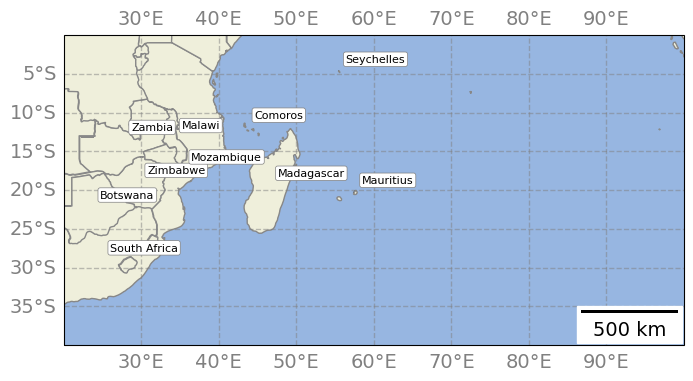

In [70]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader
from mpl_toolkits.axes_grid1 import make_axes_locatable, Size
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Define the latitude and longitude ranges for the Southwest Indian Ocean basin
lat_range = [-40, 0]
lon_range = [-340, -260]

# Create a figure and axis object with a desired projection
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Set the map boundaries
ax.set_extent(lon_range + lat_range, crs=ccrs.PlateCarree())

# Add land and ocean features
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)

# Add country borders
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
shpfilename = shpreader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()
country_names = ['Mozambique', 'Madagascar', 'Malawi', 'Zimbabwe', 'South Africa', 'Zambia', 'Seychelles', 'Botswana', 'Reunion', 'Mauritius', 'Comoros']
for country in countries:
    ax.add_geometries(country.geometry, ccrs.PlateCarree(), edgecolor='#888888', facecolor='#EFEFDB')
    if country.attributes['NAME'] in country_names:
        x = country.geometry.centroid.x        
        y = country.geometry.centroid.y
        ax.annotate(country.attributes['NAME'], 
                    xy=(x, y), 
                    xytext=(5, 5),
                    textcoords='offset points',
                    ha='left', 
                    va='bottom', 
                    fontsize=8,
                    color='black',
                    bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='gray', lw=0.5))
         
# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'gray'}
gl.ylabel_style = {'size': 14, 'color': 'gray'}

# Calculate the length of the scalebar based on map extent
lon_extent = lon_range[1] - lon_range[0]
lat_extent = lat_range[1] - lat_range[0]
scalebar_length = min(lon_extent, lat_extent) 

# Create a scalebar with the calculated distance
scalebar = ScaleBar(scalebar_length, 'km', location='lower right')
ax.add_artist(scalebar)


# Add a title to the plot
#ax.set_title("Southwest Indian Ocean Basin")

# Adjust font sizes
plt.rcParams.update({'font.size': 14})

# Show the plot
plt.show()


C:\Users\Nick\AppData\Local\Temp\ipykernel_12224\2139545083.py:17: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("YlOrRd").copy()
  cmap.set_under(alpha=0)
C:\Users\Nick\AppData\Local\Temp\ipykernel_12224\2139545083.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


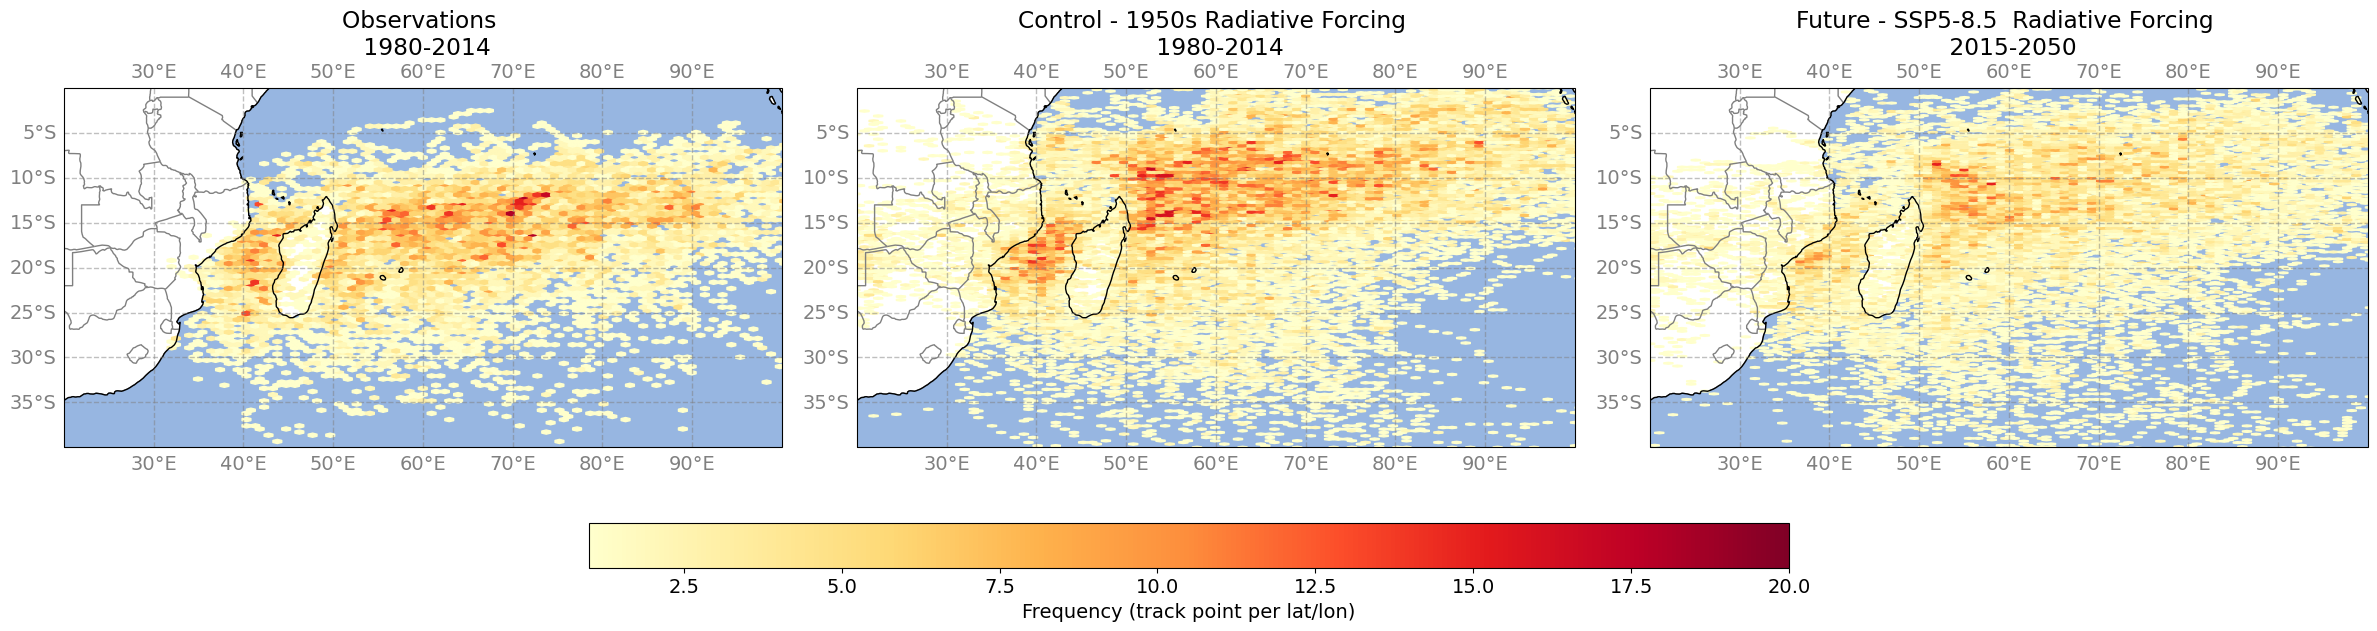

In [71]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Define the latitude and longitude ranges for the Southwest Indian Ocean basin
lat_range = [-40, 0]
lon_range = [-340, -260]

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 15), subplot_kw={'projection': ccrs.PlateCarree()})
cbar_ax = fig.add_axes([0.25, 0.3, 0.5, 0.03])  # Position and size of the colorbar axis

# Define your colormap
cmap = plt.cm.get_cmap('YlOrRd')

# Set transparency for value 0
cmap.set_under(alpha=0)


for i, ax in enumerate(axes):
    # Set the map boundaries
    ax.set_extent(lon_range + lat_range, crs=ccrs.PlateCarree())
    # Add gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 14, 'color': 'gray'}
    gl.ylabel_style = {'size': 14, 'color': 'gray'}

    # Plot the density of cyclone tracks using hexbin
    if i == 0:
        data = ibtracs_filter_df
        gridsize = 100  # Adjust the gridsize based on your preference
    elif i == 1:
        data = frequency_control
        gridsize = 350  # Adjust the gridsize based on your preference
    elif i == 2:
        data = frequency_future
        gridsize = 350  # Adjust the gridsize based on your preference

    hb = ax.hexbin(data['lon'], data['lat'],
                   gridsize=gridsize,
                   cmap='YlOrRd',  # Adjust the colormap based on your preference
                   mincnt=1,
                   alpha=1,
                   transform=ccrs.PlateCarree(),
                   vmin=1,
                   vmax=20)


    # Add a colorbar to the plot
    #cb = fig.colorbar(hb, ax=ax, shrink=0.3, label='Frequency')

    # Set a title for each subplot
    axes[0].set_title("Observations \n 1980-2014")
    axes[1].set_title("Control - 1950s Radiative Forcing \n 1980-2014")
    axes[2].set_title("Future - SSP5-8.5  Radiative Forcing \n 2015-2050")

    # Add map features
    ax.add_feature(cfeature.LAND, facecolor='white',edgecolor='grey')
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.coastlines(edgecolor='grey')
    

# Plot a single colorbar outside the subplots
cb = fig.colorbar(hb, cax=cbar_ax, orientation='horizontal', label='Frequency (track point per lat/lon)', shrink=0.3)


# Adjust font sizes
plt.rcParams.update({'font.size': 14})

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


In [136]:


import statsmodels.api as sm

def plot_regression(x_col, y_col, obs_data, control_data, future_data, x_label, y_label):
    # Create a figure with 3 subplots
    fig, axes = plt.subplots(1,2,figsize=(16, 5), gridspec_kw={'width_ratios': [0.5, 1]})
    
    # Get the colors from the 'deep' palette
    deep_palette = sns.color_palette()
    obs_color = deep_palette[0]
    control_color = deep_palette[2]
    future_color = deep_palette[1]
    line_color = 'black'

    # Create a linear regression plot for each dataset in a different subplot
    sns.regplot(data=obs_data, x=x_col, y=y_col, ax=axes[0], scatter_kws={'color': obs_color}, line_kws={'color': line_color})
    sns.regplot(data=control_data, x=x_col, y=y_col, ax=axes[1],scatter_kws={'color': control_color}, line_kws={'color': line_color})
    sns.regplot(data=future_data, x=x_col, y=y_col, ax=axes[1], scatter_kws={'color': future_color}, line_kws={'color': line_color})

    # Add a vertical line to show the edge of the second plot
    axes[1].axvline(x=control_data[x_col].max(), linestyle='--', color='gray')

    # Compute and add Pearson correlation coefficients to the plot
    pearson_obs, _ = stats.pearsonr(obs_data[x_col], obs_data[y_col])
    pearson_ctrl, _ = stats.pearsonr(control_data[x_col], control_data[y_col])
    pearson_fut, _ = stats.pearsonr(future_data[x_col], future_data[y_col])

    # Perform linear regression and compute p-values for each dataset
    obs_x = sm.add_constant(obs_data[x_col])
    obs_model = sm.OLS(obs_data[y_col], obs_x).fit()
    obs_p_value = obs_model.pvalues[x_col]

    ctrl_x = sm.add_constant(control_data[x_col])
    ctrl_model = sm.OLS(control_data[y_col], ctrl_x).fit()
    ctrl_p_value = ctrl_model.pvalues[x_col]

    fut_x = sm.add_constant(future_data[x_col])
    fut_model = sm.OLS(future_data[y_col], fut_x).fit()
    fut_p_value = fut_model.pvalues[x_col]

    # Set the titles and Pearson correlation coefficient labels for each subplot
    #axes[0].set_title("Observational 1980-2014")
    #axes[0].annotate("Pearson r = {:.4f}, p-value = {:.4f}".format(pearson_obs, obs_p_value), xy=(0.5, -0.25), xycoords='axes fraction', ha='center')
    #axes[1].set_title("Control 1980-2014 & Future 2015-2050")
    #pearson_str = "Pearson r = {:.4f} & Pearson r = {:.4f}\np-value = {:.4f} & p-value = {:.4f}".format(pearson_ctrl, pearson_fut, ctrl_p_value, fut_p_value)
    #axes[1].annotate(pearson_str, xy=(0.5, -0.25), xycoords='axes fraction', ha='center')
    axes[0].set_title("Observations \n 1980-2014")
    axes[1].set_title("Control - 1950s RF           Future - SSP5-8.5 RF \n 1980 - 2014                      2015 - 2050")


    # Set the x and y axis labels
    axes[0].set_xlabel(x_label)
    axes[0].set_ylabel(y_label)
    axes[1].set_xlabel(x_label)
    axes[1].set_ylabel(y_label)

    # Adjust the layout to avoid overlapping titles
    plt.subplots_adjust(top=0.85, hspace=0.2, right=0.9, bottom=0.15)


    # Set all to same scale
    ymin = min(obs_data[y_col].min(), control_data[y_col].min(), future_data[y_col].min())
    ymax = max(obs_data[y_col].max(), control_data[y_col].max(), future_data[y_col].max())
    xmin = min(obs_data[x_col].min(), control_data[x_col].min(), future_data[x_col].min())
    xmax = max(obs_data[x_col].max(), control_data[x_col].max(), future_data[x_col].max())


   
    # Create the text strings for the correlation coefficients
    ax1textstr = f'Pearson r: {pearson_obs:.4f}'
    ax2textstr = f'Pearson r: {pearson_ctrl:.4f}'
    ax3textstr = f'Pearson r: {pearson_fut:.4f}'

    # Create the text box properties
    props = dict(facecolor='white', alpha=0.5)
    
    # Add the text boxes to the plots
    # Add the text boxes to the plots
    axes[0].annotate(ax1textstr, xy=(0, 1), xycoords='axes fraction', fontsize=12,
                    xytext=(5, -5), textcoords='offset points', ha='left', va='top', bbox=props)
    axes[1].annotate(ax2textstr, xy=(0, 1), xycoords='axes fraction', fontsize=12,
                    xytext=(5, -5), textcoords='offset points', ha='left', va='top', bbox=props)
    axes[1].annotate(ax3textstr, xy=(1, 1), xycoords='axes fraction', fontsize=12,
                    xytext=(-5, -5), textcoords='offset points', ha='right', va='top', bbox=props)



    # Add padding to the y-axis limits
    y_padding = 0.1 * (ymax - ymin)  # Adjust the padding factor as desired
    ymin -= y_padding
    ymax += y_padding

    # Set the same y-axis limits for both subplots
    axes[0].set_ylim([ymin, ymax])
    axes[1].set_ylim([ymin, ymax])

    plt.rcParams.update({'font.size': 14})

    plt.savefig(r'D:\\Masters_Thesis\\Report_Writing\\figures\\linear_regression_{}_{}_all_basin.pdf'.format(x_label, y_label.replace('/', '_')), bbox_inches='tight')

    print(pearson_obs,
    obs_p_value,
    pearson_ctrl,
    ctrl_p_value,
    pearson_fut,
    fut_p_value)


    # Display the plot
    plt.show()


0.03420749055300208 0.8453291704808286 -0.01334325366403534 0.9393585200965309 -0.026205162019744363 0.8812167334479573


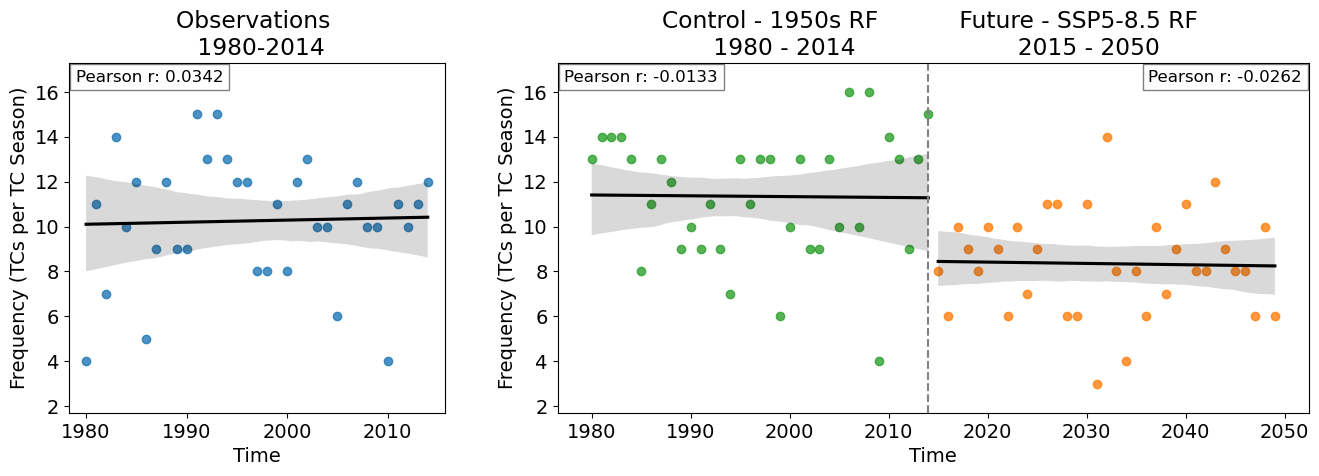

In [137]:
plot_regression("season","frequency",obs_storms_per_season,control_storms_per_season,future_storms_per_season, "Time", "Frequency (TCs per TC Season)")


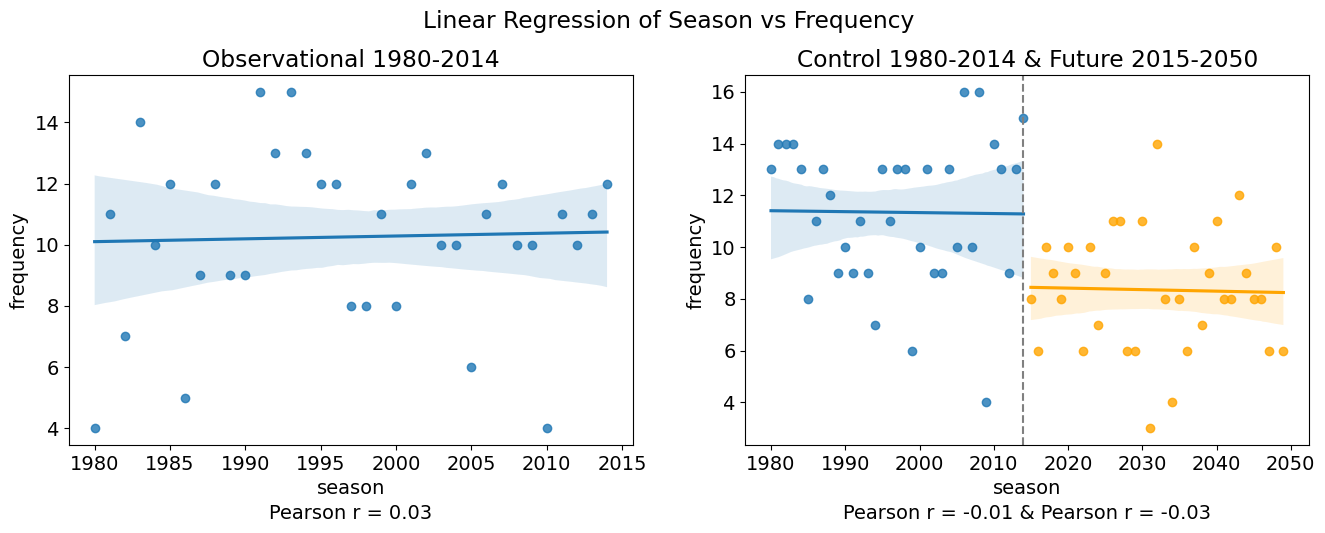

In [74]:
# Create a figure with 3 subplots
fig, axes = plt.subplots(1,2,figsize=(16, 5), gridspec_kw={'width_ratios': [1, 1]})

# Create a linear regression plot for each dataset in a different subplot
sns.regplot(data=obs_storms_per_season, x="season", y="frequency", ax=axes[0])
sns.regplot(data=control_storms_per_season, x="season", y="frequency", ax=axes[1])
sns.regplot(data=future_storms_per_season, x="season", y="frequency", ax=axes[1], color='orange')

# Add a vertical line to show the edge of the second plot
axes[1].axvline(x=obs_storms_per_season["season"].max(), linestyle='--', color='gray')

# Compute and add Pearson correlation coefficients to the plot
pearson_obs, _ = stats.pearsonr(obs_storms_per_season["season"], obs_storms_per_season["frequency"])
pearson_ctrl, _ = stats.pearsonr(control_storms_per_season["season"], control_storms_per_season["frequency"])
pearson_fut, _ = stats.pearsonr(future_storms_per_season["season"], future_storms_per_season["frequency"])

# Set the titles and Pearson correlation coefficient labels for each subplot
axes[0].set_title("Observational 1980-2014")
axes[0].annotate("Pearson r = {:.2f}".format(pearson_obs), xy=(0.5, -0.2), xycoords='axes fraction', ha='center')
axes[1].set_title("Control 1980-2014 & Future 2015-2050")
pearson_str = "Pearson r = {:.2f} & Pearson r = {:.2f}".format(pearson_ctrl, pearson_fut)
axes[1].annotate(pearson_str, xy=(0.5, -0.2), xycoords='axes fraction', ha='center')


# Add a title to the entire figure
fig.suptitle("Linear Regression of Season vs Frequency")

# Adjust the layout to avoid overlapping titles
plt.subplots_adjust(top=0.85, hspace=0.2, right=0.9)

#Set all to same scale
ymin = min(obs_storms_per_season['frequency'].min(), control_storms_per_season['frequency'].min(), future_storms_per_season['frequency'].min())
ymax = max(obs_storms_per_season['frequency'].max(), control_storms_per_season['frequency'].max(), future_storms_per_season['frequency'].max())
xmin = min(obs_storms_per_season['season'].min(), control_storms_per_season['season'].min(), future_storms_per_season['season'].min())
xmax = max(obs_storms_per_season['season'].max(), control_storms_per_season['season'].max(), future_storms_per_season['season'].max())

# Display the plot
plt.show()

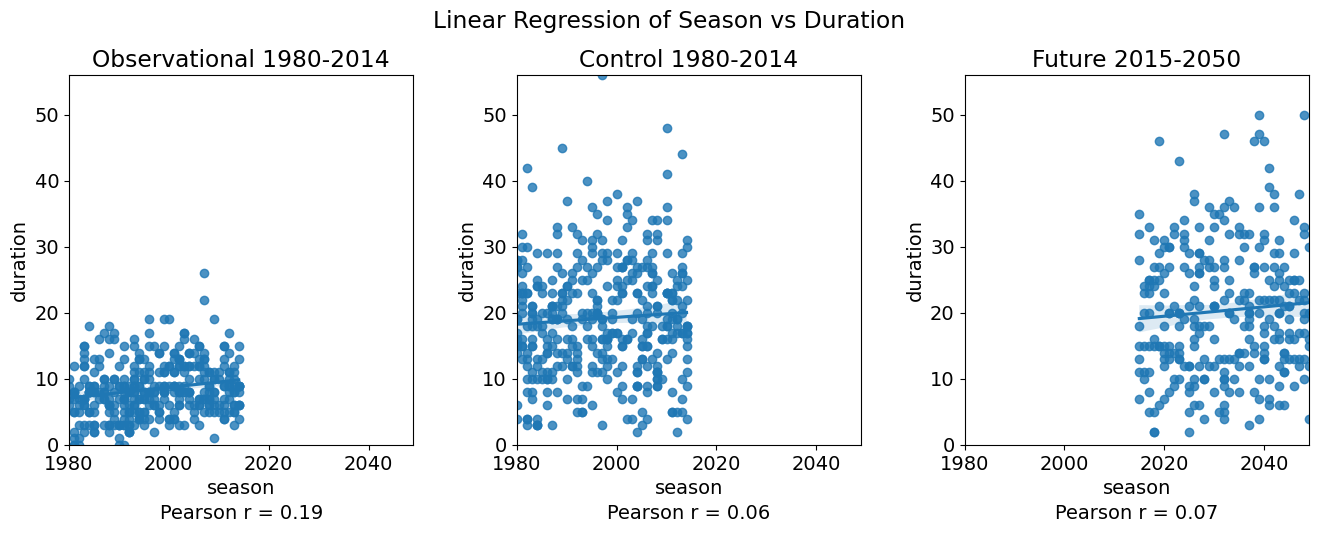

In [75]:
# Create a figure with 3 subplots
fig, axes = plt.subplots(1,3,figsize=(16, 5))

# Create a linear regression plot for each dataset in a different subplot
sns.regplot(data=obs_df, x="season", y="duration", ax=axes[0])
sns.regplot(data=control_df, x="season", y="duration", ax=axes[1])
sns.regplot(data=future_df, x="season", y="duration", ax=axes[2])

# Compute and add Pearson correlation coefficients to the plot
pearson_obs, _ = stats.pearsonr(obs_df["season"], obs_df["duration"])
pearson_ctrl, _ = stats.pearsonr(control_df["season"], control_df["duration"])
pearson_fut, _ = stats.pearsonr(future_df["season"], future_df["duration"])

# Set the titles and Pearson correlation coefficient labels for each subplot
axes[0].set_title("Observational 1980-2014")
axes[0].annotate("Pearson r = {:.2f}".format(pearson_obs), xy=(0.5, -0.2), xycoords='axes fraction', ha='center')
axes[1].set_title("Control 1980-2014")
axes[1].annotate("Pearson r = {:.2f}".format(pearson_ctrl), xy=(0.5, -0.2), xycoords='axes fraction', ha='center')
axes[2].set_title("Future 2015-2050")
axes[2].annotate("Pearson r = {:.2f}".format(pearson_fut), xy=(0.5, -0.2), xycoords='axes fraction', ha='center')

# Add a title to the entire figure
fig.suptitle("Linear Regression of Season vs Duration")

# Adjust the layout to avoid overlapping titles
plt.subplots_adjust(top=0.85,  wspace=0.3)

#Set all to same scale
ymin = min(obs_df['duration'].min(), control_df['duration'].min(), future_df['duration'].min())
ymax = max(obs_df['duration'].max(), control_df['duration'].max(), future_df['duration'].max())
xmin = min(obs_df['season'].min(), control_df['season'].min(), future_df['season'].min())
xmax = max(obs_df['season'].max(), control_df['season'].max(), future_df['season'].max())
for ax in axes:
    ax.set_ylim([ymin, ymax])
    ax.set_xlim([xmin, xmax])

# Display the plot
plt.show()

0.19053543076007326 0.0002824807032413021 0.06290242714468249 0.2110772415266384 0.07246338655606915 0.21699159080919553


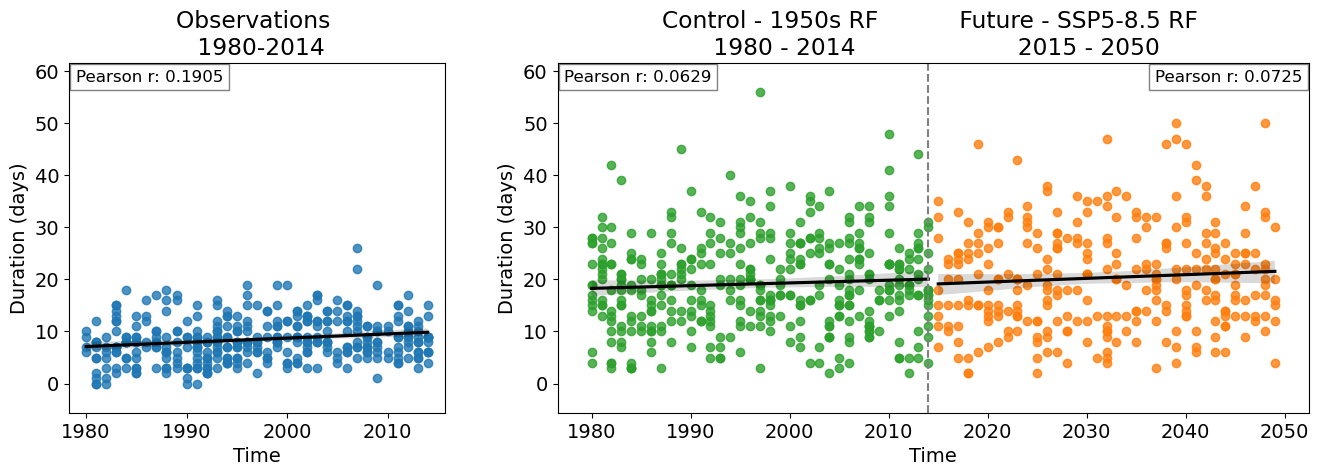

In [138]:
plot_regression("season","duration",obs_df,control_df,future_df, "Time", "Duration (days)")

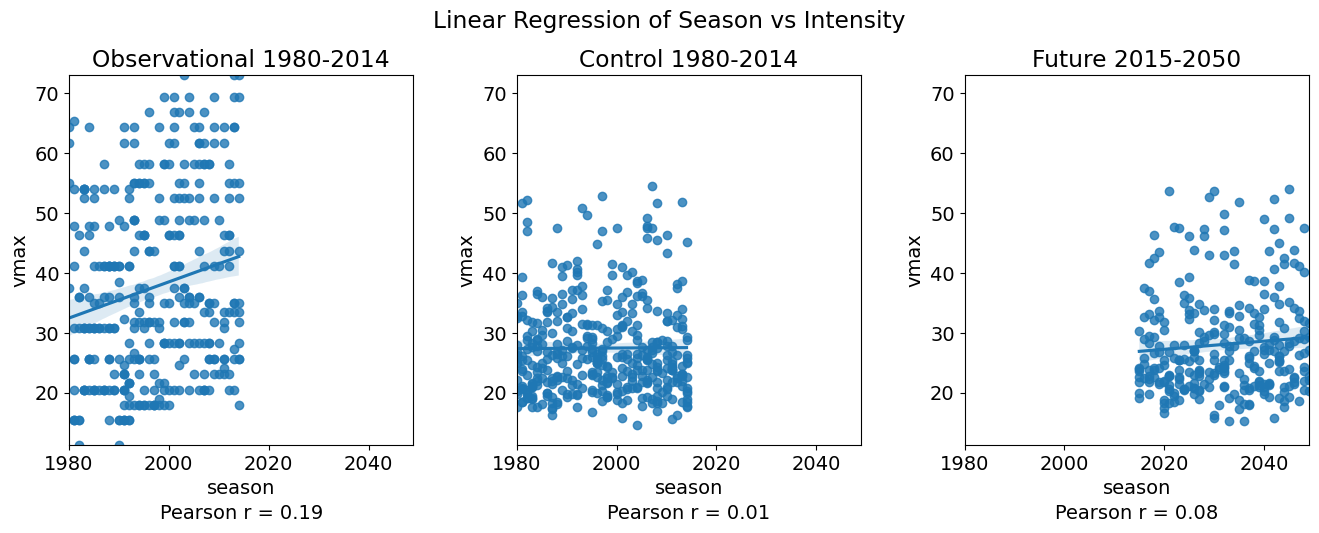

In [77]:
# Create a figure with 3 subplots
fig, axes = plt.subplots(1,3,figsize=(16, 5))

# Create a linear regression plot for each dataset in a different subplot
sns.regplot(data=obs_df, x="season", y="vmax", ax=axes[0])
sns.regplot(data=control_df, x="season", y="vmax", ax=axes[1])
sns.regplot(data=future_df, x="season", y="vmax", ax=axes[2])

# Compute and add Pearson correlation coefficients to the plot
pearson_obs, _ = stats.pearsonr(obs_df["season"], obs_df["vmax"])
pearson_ctrl, _ = stats.pearsonr(control_df["season"], control_df["vmax"])
pearson_fut, _ = stats.pearsonr(future_df["season"], future_df["vmax"])

# Set the titles and Pearson correlation coefficient labels for each subplot
axes[0].set_title("Observational 1980-2014")
axes[0].annotate("Pearson r = {:.2f}".format(pearson_obs), xy=(0.5, -0.2), xycoords='axes fraction', ha='center')
axes[1].set_title("Control 1980-2014")
axes[1].annotate("Pearson r = {:.2f}".format(pearson_ctrl), xy=(0.5, -0.2), xycoords='axes fraction', ha='center')
axes[2].set_title("Future 2015-2050")
axes[2].annotate("Pearson r = {:.2f}".format(pearson_fut), xy=(0.5, -0.2), xycoords='axes fraction', ha='center')

# Add a title to the entire figure
fig.suptitle("Linear Regression of Season vs Intensity")

# Adjust the layout to avoid overlapping titles
plt.subplots_adjust(top=0.85,  wspace=0.3)

ymin = min(obs_df['vmax'].min(), control_df['vmax'].min(), future_df['vmax'].min())
ymax = max(obs_df['vmax'].max(), control_df['vmax'].max(), future_df['vmax'].max())
xmin = min(obs_df['season'].min(), control_df['season'].min(), future_df['season'].min())
xmax = max(obs_df['season'].max(), control_df['season'].max(), future_df['season'].max())
for ax in axes:
    ax.set_ylim([ymin, ymax])
    ax.set_xlim([xmin, xmax])


# Display the plot
plt.show()

0.1935388200449185 0.00022497048099417083 0.006315261092064324 0.9001790470498737 0.08098538030243943 0.1675216849228386


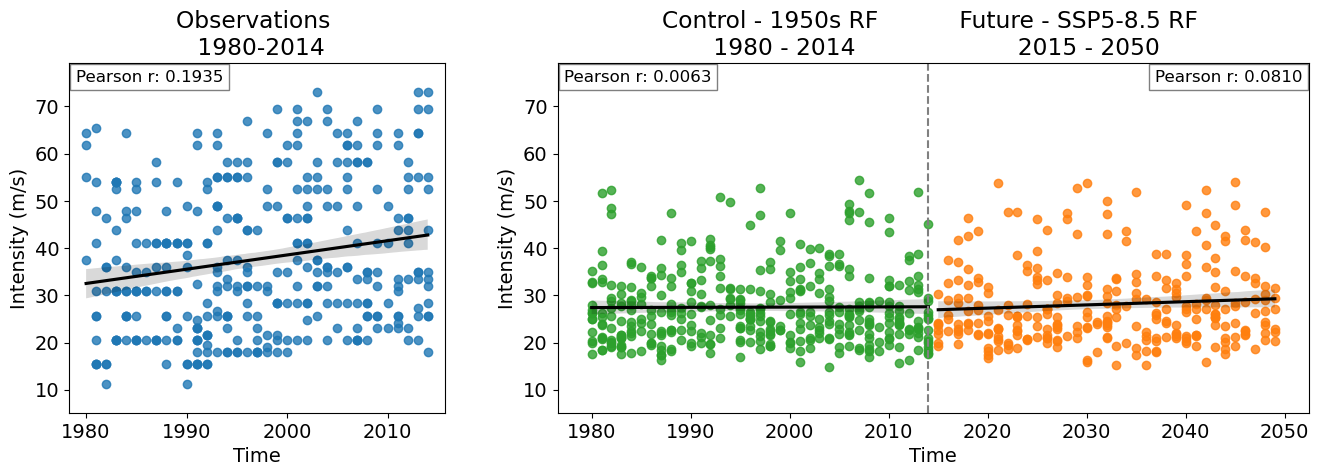

In [139]:
plot_regression("season","vmax",obs_df,control_df,future_df, "Time", "Intensity (m/s)")

In [79]:
def plot_running_means(x_col, y_col, obs_data, control_data, future_data):
    
    # Define color palette
    colors = sns.color_palette("Set1", 4)
    
    # Create a figure with 3 subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 5), gridspec_kw={'width_ratios': [1, 1]})
    

    # Create scatterplots and running means for each dataset in a different subplot
    window_size = 5

    # for data below 25th percentile line
    obs_data_below25 = obs_data[obs_data[y_col] < np.percentile(obs_data[y_col], 25)]
    rolling_obs_below25 = obs_data_below25[y_col].rolling(window_size, center=True).mean()
    control_data_below25 = control_data[control_data[y_col] < np.percentile(control_data[y_col], 25)]
    rolling_ctrl_below25 = control_data_below25[y_col].rolling(window_size, center=True).mean()
    future_data_below25 = future_data[future_data[y_col] < np.percentile(future_data[y_col], 25)]
    rolling_fut_below25 = future_data_below25[y_col].rolling(window_size, center=True).mean()

    #sns.scatterplot(data=obs_data_below25, x=x_col, y=y_col, alpha=0.5, ax=axes[0], color=colors[1])
    sns.lineplot(data=rolling_obs_below25, x=obs_data_below25[x_col], y=rolling_obs_below25, ax=axes[0], color=colors[1])
    #sns.regplot(data=obs_data_below25, x=x_col, y=y_col, scatter=False, ax=axes[0], color=colors[1])
    

    #sns.scatterplot(data=control_data_below25, x=x_col, y=y_col, alpha=0.5, ax=axes[1], color=colors[1])
    sns.lineplot(data=rolling_ctrl_below25, x=control_data_below25[x_col], y=rolling_ctrl_below25, ax=axes[1], color=colors[1])
    

    #sns.scatterplot(data=future_data_below25, x=x_col, y=y_col, alpha=0.5, ax=axes[1], color=colors[1] )
    sns.lineplot(data=rolling_fut_below25, x=future_data_below25[x_col], y=rolling_fut_below25, ax=axes[1], color=colors[1])
    
    # for data between 25th and 75th percentile lines
    obs_data_25to75 = obs_data[(obs_data[y_col] >= np.percentile(obs_data[y_col], 25)) & 
                               (obs_data[y_col] <= np.percentile(obs_data[y_col], 75))]
    rolling_obs_25to75 = obs_data_25to75[y_col].rolling(window_size, center=True).mean()
    control_data_25to75 = control_data[(control_data[y_col] >= np.percentile(control_data[y_col], 25)) & 
                                       (control_data[y_col] <= np.percentile(control_data[y_col], 75))]

    rolling_ctrl_25to75 = control_data_25to75[y_col].rolling(window_size, center=True).mean()
    future_data_25to75 = future_data[(future_data[y_col] >= np.percentile(future_data[y_col], 25)) & 
                                     (future_data[y_col] <= np.percentile(future_data[y_col], 75))]
    rolling_fut_25to75 = future_data_25to75[y_col].rolling(window_size, center=True).mean()
    
    #sns.scatterplot(data=obs_data_25to75, x=x_col, y=y_col, alpha=0.5, ax=axes[0], color=colors[2])
    sns.lineplot(data=rolling_obs_25to75, x=obs_data_25to75[x_col], y=rolling_obs_25to75, ax=axes[0], color=colors[2])
    #sns.regplot(data=obs_data_25to75, x=x_col, y=y_col, scatter=False, ax=axes[0], color=colors[2])

    #sns.scatterplot(data=control_data_25to75, x=x_col, y=y_col, alpha=0.5, ax=axes[1], color=colors[2])
    sns.lineplot(data=rolling_ctrl_25to75, x=control_data_25to75[x_col], y=rolling_ctrl_25to75, ax=axes[1], color=colors[2])

    #sns.scatterplot(data=future_data_25to75, x=x_col, y=y_col, alpha=0.5, ax=axes[1], color=colors[2])
    sns.lineplot(data=rolling_fut_25to75, x=future_data_25to75[x_col], y=rolling_fut_25to75, ax=axes[1], color=colors[2])
    
    
    # for data above 75th percentile line
    obs_data_above75 = obs_data[obs_data[y_col] > np.percentile(obs_data[y_col], 75)]
    rolling_obs_above75 = obs_data_above75[y_col].rolling(window_size, center=True).mean()
    control_data_above75 = control_data[control_data[y_col] > np.percentile(control_data[y_col], 75)]
    rolling_ctrl_above75 = control_data_above75[y_col].rolling(window_size, center=True).mean()
    future_data_above75 = future_data[future_data[y_col] > np.percentile(future_data[y_col], 75)]
    rolling_fut_above75 = future_data_above75[y_col].rolling(window_size, center=True).mean()

    #sns.scatterplot(data=obs_data_above75, x=x_col, y=y_col, alpha=0.5, ax=axes[0], color=colors[3])
    sns.lineplot(data=rolling_obs_above75, x=obs_data_above75[x_col], y=rolling_obs_above75, ax=axes[0], color=colors[3])
    #sns.regplot(data=obs_data_above75, x=x_col, y=y_col, scatter=False, ax=axes[0], color=colors[3])
    
    #sns.scatterplot(data=control_data_above75, x=x_col, y=y_col, alpha=0.5, ax=axes[1], color=colors[3])
    sns.lineplot(data=rolling_ctrl_above75, x=control_data_above75[x_col], y=rolling_ctrl_above75, ax=axes[1], color=colors[3])
    
    #sns.scatterplot(data=future_data_above75, x=x_col, y=y_col, alpha=0.5, ax=axes[1], color=colors[3])
    sns.lineplot(data=rolling_fut_above75, x=future_data_above75[x_col], y=rolling_fut_above75, ax=axes[1], color=colors[3])
    #sns.regplot(data=future_data_above75, x=x_col, y=y_col, scatter=False, ax=axes[0], color=colors[3])

    #Identify percentiles
    obs_data_percentiles = np.percentile(obs_data[y_col], [25, 50, 75])
    control_data_percentiles = np.percentile(control_data[y_col], [25, 50, 75])
    future_data_percentiles = np.percentile(future_data[y_col], [25, 50, 75])

    # Plot dashed percentile lines
    axes[0].hlines(obs_data_percentiles, xmin=obs_data[x_col].min(), xmax=obs_data[x_col].max(),
                linestyles="--", colors="gray", label="25th, 50th, and 75th percentiles")
    axes[1].hlines(control_data_percentiles, xmin=control_data[x_col].min(), xmax=control_data[x_col].max(),
                   linestyles="--", colors="gray", label="25th, 50th, and 75th percentiles")
    axes[1].hlines(future_data_percentiles, xmin=future_data[x_col].min(), xmax=future_data[x_col].max(),
                   linestyles="--", colors="gray")

    # Add a vertical line to show the edge of the second plot
    axes[1].axvline(x=obs_data[x_col].max(), linestyle='--', color='gray')
    
    # Add a title to the entire figure
    fig.suptitle(" 5-year running means of {} vs {} for the 25th, 50th, and 75th percentile".format(x_col, y_col))

    # Adjust the layout to avoid overlapping titles
    plt.subplots_adjust(top=0.85, hspace=0.2, right=0.9)

    ymin = min(obs_df['vmax'].min(), control_df['vmax'].min(), future_df['vmax'].min())
    ymax = max(obs_df['vmax'].max(), control_df['vmax'].max(), future_df['vmax'].max())
    xmin = min(obs_df['season'].min(), control_df['season'].min(), future_df['season'].min())
    xmax = max(obs_df['season'].max(), control_df['season'].max(), future_df['season'].max())

    #for ax in axes:
        #ax.set_ylim([ymin, ymax])
        #ax.set_xlim([xmin, xmax])
        
    # Set the titles and Pearson correlation coefficient labels for each subplot
    axes[0].set_title("Observational 1980-2014")
    axes[1].set_title("Control 1980-2014 & Future 2015-2050")
   

    # Display the plot
    plt.show()

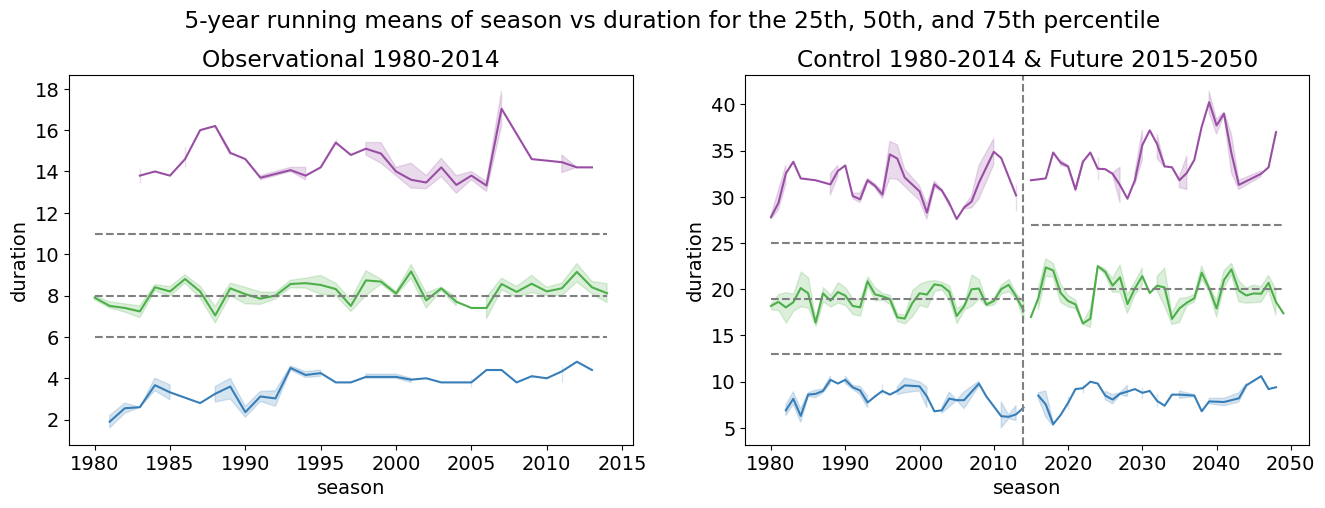

In [80]:
plot_running_means("season","duration", obs_df, control_df, future_df)

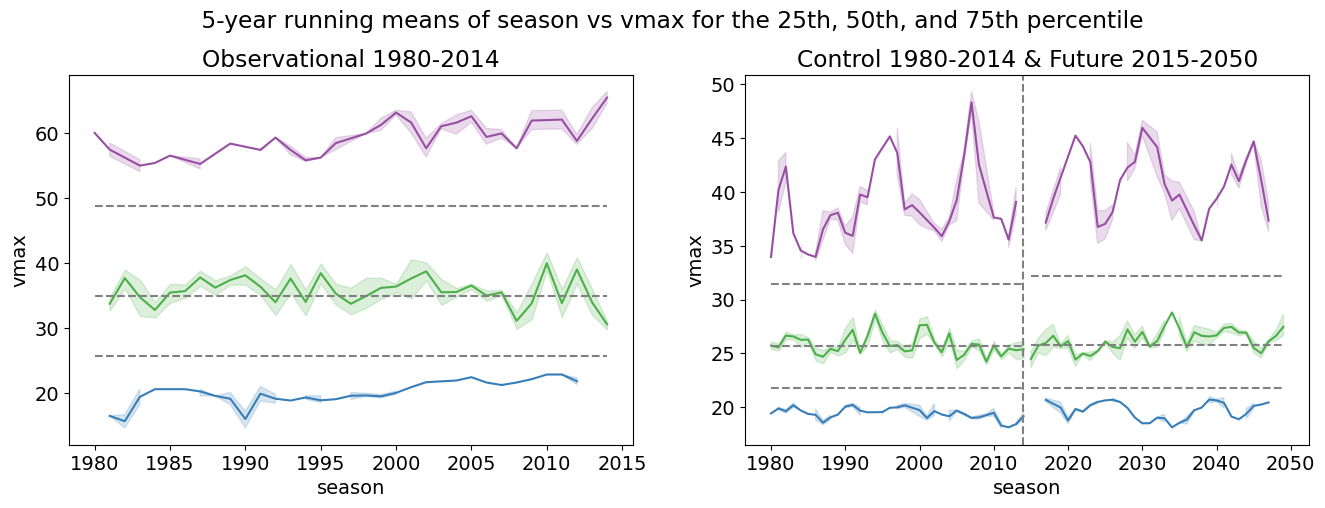

In [81]:
plot_running_means("season","vmax", obs_df, control_df, future_df)

In [82]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_running_means(x_col, y_col, obs_data, control_data, future_data, x_label, y_label):
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    window_size = 5

    # Calculate running mean for each percentile in control_data
    control_percentiles = np.percentile(control_data[y_col], [25, 50, 75])
    control_running_means = [
        control_data[control_data[y_col] <= p][y_col].rolling(window=window_size, center=True).mean()
        for p in control_percentiles
    ]

    # Plot running means for each percentile in control_data
    colors = ["red", "green", "blue"]
    for i, running_mean in enumerate(control_running_means):
        sns.lineplot(data=running_mean, x=control_data[x_col], y=running_mean, ax=axes[0], color=colors[i], ci=None)

    # Calculate running mean for each percentile in future_data
    future_running_means = []
    for x_value in future_data[x_col].unique():
        x_data = future_data[future_data[x_col] == x_value]
        percentiles = np.percentile(x_data[y_col], [25, 50, 75])
        running_means = [
            x_data[x_data[y_col] <= p][y_col].rolling(window=window_size, center=True).mean()
            for p in percentiles
        ]
        future_running_means.extend(running_means)

        # Plot running means for each percentile in future_data
        for i, running_mean in enumerate(future_running_means):
            sns.lineplot(data=running_mean, x=x_data[x_col], y=running_mean, ax=axes[1], color=colors[i], ci=None)

    # Set x-axis and y-axis labels
    axes[0].set_xlabel(x_label)
    axes[0].set_ylabel(y_label)
    axes[1].set_xlabel(x_label)
    axes[1].set_ylabel(y_label)

    # Get the minimum and maximum y-values across both subplots
    control_min = min([np.nanmin(rm) for rm in control_running_means])
    future_min = min([np.nanmin(rm) for rm in future_running_means])
    ymin = min(control_min, future_min)

    # Get the maximum y-value across both subplots
    control_max = max([np.nanmax(rm) for rm in control_running_means])
    future_max = max([np.nanmax(rm) for rm in future_running_means])
    ymax = max(control_max, future_max)

    # Set the same y-axis limits for both subplots
    axes[0].set_ylim([ymin, ymax])
    axes[1].set_ylim([ymin, ymax])

    # Show the plot
    plt.tight_layout()
    plt.show()


In [126]:
def plot_running_means(x_col, y_col, obs_data, control_data, future_data, x_label, y_label):
    # Define color palette
    colors = sns.color_palette("viridis", 3)

    # Create a figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 5), gridspec_kw={'width_ratios': [0.5, 1]})

    # Create scatterplots and running means for each dataset in a different subplot
    window_size = 5

    # Plot running means for each percentile in obs_data
    for i, p in enumerate([25, 50, 75]):
        obs_running_mean = obs_data[y_col].rolling(window_size, center=True).quantile(p/100)
        sns.lineplot(data=obs_running_mean, x=obs_data[x_col], y=obs_running_mean, ax=axes[0], color=colors[i], ci=None)

    # Plot running means for each percentile in control_data
    for i, p in enumerate([25, 50, 75]):
        control_running_mean = control_data[y_col].rolling(window_size, center=True).quantile(p/100)
        sns.lineplot(data=control_running_mean, x=control_data[x_col], y=control_running_mean, ax=axes[1], color=colors[i], ci=None)

    # Plot running means for each percentile in future_data
    for i, p in enumerate([25, 50, 75]):
        future_running_mean = future_data[y_col].rolling(window_size, center=True).quantile(p/100)
        sns.lineplot(data=future_running_mean, x=future_data[x_col], y=future_running_mean, ax=axes[1], color=colors[i], ci=None)

    # Add a vertical line to show the edge of the second plot
    axes[1].axvline(x=obs_data[x_col].max(), linestyle='--', color='gray')

    # Add a title to the entire figure
    #fig.suptitle("5-year running means of {} vs {} for the 25th, 50th, and 75th percentile".format(x_label, y_label))

    # Adjust the layout to avoid overlapping titles
    plt.subplots_adjust(top=0.85, hspace=0.2, right=0.9)

    # Determine y-axis limits for both subplots
    ymin = min([running_mean.min() for running_mean in [obs_running_mean, control_running_mean, future_running_mean]])
    ymax = max([running_mean.max() for running_mean in [obs_running_mean, control_running_mean, future_running_mean]])

    # Set the same y-axis limits for both subplots
    axes[0].set_ylim([ymin, ymax])
    axes[1].set_ylim([ymin, ymax])

    # Add a legend for the observational dataset
    legend_labels = ['25th Percentile', '50th Percentile', '75th Percentile']
    legend_colors = [colors[0], colors[1], colors[2]]  # Corresponding colors for the legend labels
    axes[0].legend(labels=legend_labels, handles=[plt.Line2D([0], [0], color=c, linestyle='-') for c in legend_colors])

    # Add gridlines to both subplots
    axes[0].grid(True)
    axes[1].grid(True)

    # Set the x and y axis labels
    axes[0].set_xlabel(x_label)
    axes[0].set_ylabel(y_label)
    axes[1].set_xlabel(x_label)
    axes[1].set_ylabel(y_label)

    # Set the titles for each subplot
    axes[0].set_title("Observations \n 1980-2014")
    axes[1].set_title("Control - 1950s RF           Future - SSP5-8.5 RF \n 1980 - 2014                      2015 - 2050")

    plt.rcParams.update({'font.size': 14})

    #plt.savefig(r'D:\\Masters_Thesis\\Report_Writing\\figures\\percentile_{}_{}_all_basin.pdf'.format(x_label, y_label), bbox_inches='tight')
    plt.savefig(r'D:\\Masters_Thesis\\Report_Writing\\figures\percentile_{}_{}_all_basin.pdf'.format(x_label, y_label.replace('/', '_')), bbox_inches='tight')


    # Display the plot
    plt.show()



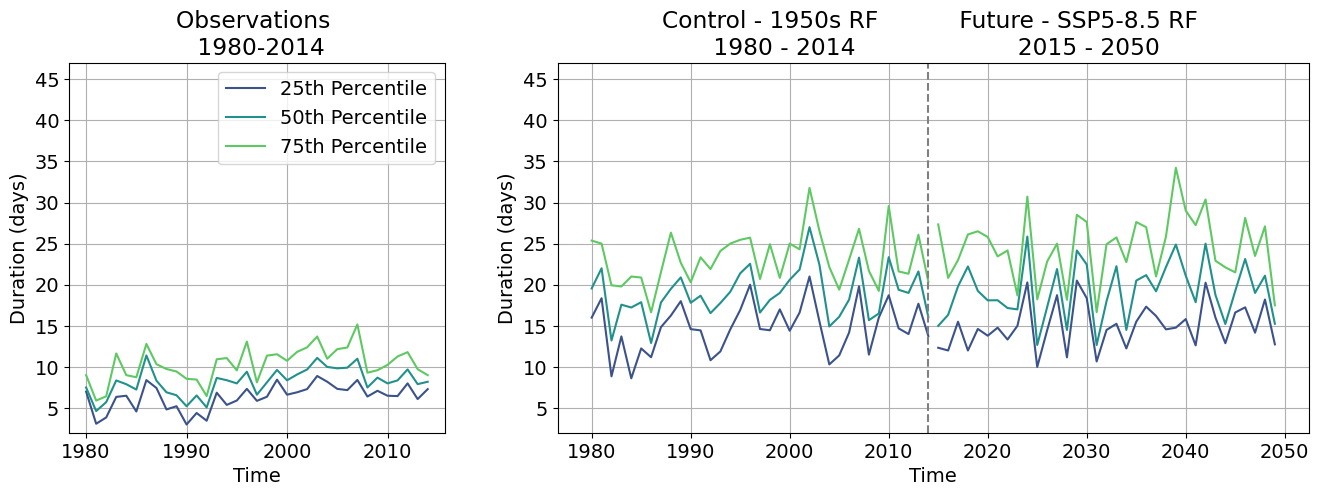

In [127]:
plot_running_means("season","duration", obs_df, control_df, future_df, "Time", "Duration (days)")

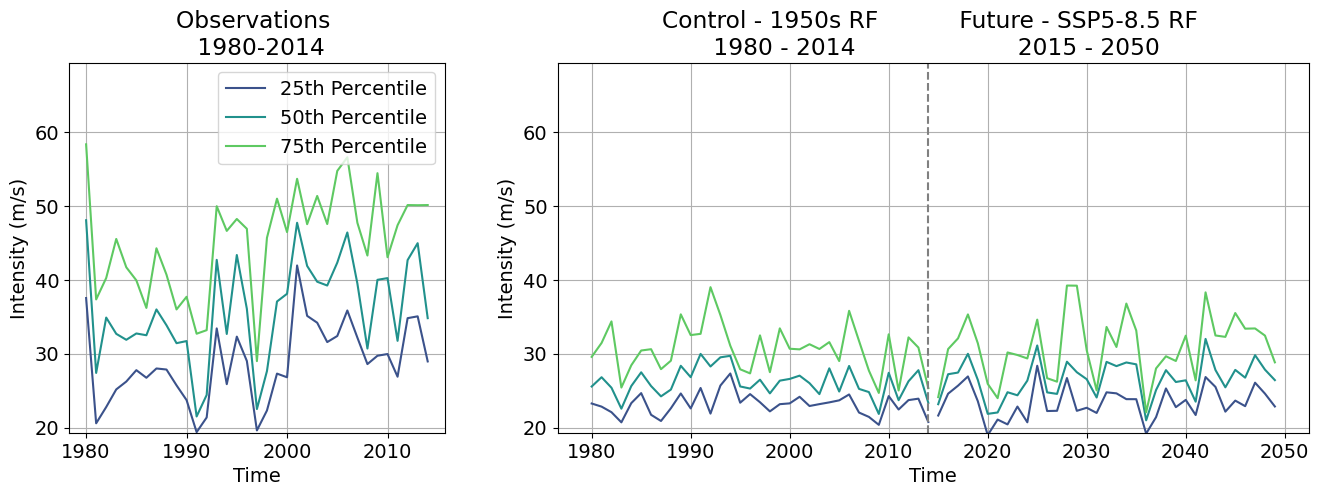

In [128]:
plot_running_means("season","vmax", obs_df, control_df, future_df, "Time", "Intensity (m/s)")

In [86]:
def calculate_and_print_statistics(data, x_col, y_col):
    # Compute Pearson correlation coefficient
    pearson_coef, _ = stats.pearsonr(data[x_col], data[y_col])
    
    # Perform linear regression and compute p-value
    x = sm.add_constant(data[x_col])
    model = sm.OLS(data[y_col], x).fit()
    p_value = model.pvalues[x_col]

    # Round to 4 significant figures
    pearson_coef = round(pearson_coef, 4)
    p_value = round(p_value, 4)
    
    # Print the results
    print(" Pearson correlation coefficient:", pearson_coef)
    print(" Linear regression p-value:", p_value)
    print()

In [87]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_running_means(x_col, y_col, obs_data, control_data, future_data, x_label, y_label):
    # Define color palette
    colors = sns.color_palette("Set1", 4)
    
    # Create a figure with 3 subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 5), gridspec_kw={'width_ratios': [0.5, 1]})
    
    # Create scatterplots and linear regressions for each dataset in a different subplot
    window_size = 5
    
    # for data below 25th percentile line
    obs_data_below25 = obs_data[obs_data[y_col] < np.percentile(obs_data[y_col], 25)]
    rolling_obs_below25 = obs_data_below25[y_col].rolling(window_size, center=True).mean()
    control_data_below25 = control_data[control_data[y_col] < np.percentile(control_data[y_col], 25)]
    rolling_ctrl_below25 = control_data_below25[y_col].rolling(window_size, center=True).mean()
    future_data_below25 = future_data[future_data[y_col] < np.percentile(future_data[y_col], 25)]
    rolling_fut_below25 = future_data_below25[y_col].rolling(window_size, center=True).mean()

    sns.scatterplot(data=obs_data_below25, x=x_col, y=y_col, alpha=0.5, ax=axes[0], color=colors[1])
    sns.regplot(data=obs_data_below25, x=x_col, y=y_col, scatter=False, ax=axes[0], color=colors[1])
    sns.scatterplot(data=control_data_below25, x=x_col, y=y_col, alpha=0.5, ax=axes[1], color=colors[1])
    sns.regplot(data=control_data_below25, x=x_col, y=y_col, scatter=False, ax=axes[1], color=colors[1])
    sns.scatterplot(data=future_data_below25, x=x_col, y=y_col, alpha=0.5, ax=axes[1], color=colors[1])
    sns.regplot(data=future_data_below25, x=x_col, y=y_col, scatter=False, ax=axes[1], color=colors[1])

    # for data between 25th and 75th percentile lines
    obs_data_25to75 = obs_data[(obs_data[y_col] >= np.percentile(obs_data[y_col], 25)) & 
                               (obs_data[y_col] <= np.percentile(obs_data[y_col], 75))]
    rolling_obs_25to75 = obs_data_25to75[y_col].rolling(window_size, center=True).mean()
    control_data_25to75 = control_data[(control_data[y_col] >= np.percentile(control_data[y_col], 25)) & 
                                       (control_data[y_col] <= np.percentile(control_data[y_col], 75))]
    rolling_ctrl_25to75 = control_data_25to75[y_col].rolling(window_size, center=True).mean()
    future_data_25to75 = future_data[(future_data[y_col] >= np.percentile(future_data[y_col], 25)) & 
                                       (future_data[y_col] <= np.percentile(future_data[y_col], 75))]
    rolling_fut_25to75 = future_data_25to75[y_col].rolling(window_size, center=True).mean()

    sns.scatterplot(data=obs_data_25to75, x=x_col, y=y_col, alpha=0.5, ax=axes[0], color=colors[2])
    sns.regplot(data=obs_data_25to75, x=x_col, y=y_col, scatter=False, ax=axes[0], color=colors[2])
    sns.scatterplot(data=control_data_25to75, x=x_col, y=y_col, alpha=0.5, ax=axes[1], color=colors[2])
    sns.regplot(data=control_data_25to75, x=x_col, y=y_col, scatter=False, ax=axes[1], color=colors[2])
    sns.scatterplot(data=future_data_25to75, x=x_col, y=y_col, alpha=0.5, ax=axes[1], color=colors[2])
    sns.regplot(data=future_data_25to75, x=x_col, y=y_col, scatter=False, ax=axes[1], color=colors[2])
    

    # for data over the 75th percentile line
    
    obs_data_above75 = obs_data[obs_data[y_col] > np.percentile(obs_data[y_col], 75)]
    rolling_obs_above75 = obs_data_above75[y_col].rolling(window_size, center=True).mean()
    control_data_above75 = control_data[control_data[y_col] > np.percentile(control_data[y_col], 75)]
    rolling_ctrl_above75 = control_data_above75[y_col].rolling(window_size, center=True).mean()
    future_data_above75 = future_data[future_data[y_col] > np.percentile(future_data[y_col], 75)]
    rolling_fut_above75 = future_data_above75[y_col].rolling(window_size, center=True).mean()

    sns.scatterplot(data=obs_data_above75, x=x_col, y=y_col, alpha=0.5, ax=axes[0], color=colors[3])
    sns.regplot(data=obs_data_above75, x=x_col, y=y_col, scatter=False, ax=axes[0], color=colors[3])
    sns.scatterplot(data=control_data_above75, x=x_col, y=y_col, alpha=0.5, ax=axes[1], color=colors[3])
    sns.regplot(data=control_data_above75, x=x_col, y=y_col, scatter=False, ax=axes[1], color=colors[3])
    sns.scatterplot(data=future_data_above75, x=x_col, y=y_col, alpha=0.5, ax=axes[1], color=colors[3])
    sns.regplot(data=future_data_above75, x=x_col, y=y_col, scatter=False, ax=axes[1], color=colors[3])

    #Identify percentiles
    obs_data_percentiles = np.percentile(obs_data[y_col], [25, 50, 75])
    control_data_percentiles = np.percentile(control_data[y_col], [25, 50, 75])
    future_data_percentiles = np.percentile(future_data[y_col], [25, 50, 75])

    # Plot dashed percentile lines
    axes[0].hlines(obs_data_percentiles, xmin=obs_data[x_col].min(), xmax=obs_data[x_col].max(),
                linestyles="--", colors="gray", label="25th, 50th, and 75th percentiles")
    axes[1].hlines(control_data_percentiles, xmin=control_data[x_col].min(), xmax=control_data[x_col].max(),
                   linestyles="--", colors="gray", label="25th, 50th, and 75th percentiles")
    axes[1].hlines(future_data_percentiles, xmin=future_data[x_col].min(), xmax=future_data[x_col].max(),
                   linestyles="--", colors="gray")

    # Calculate and print statistics for each dataset and percentile range
    calculate_and_print_statistics(obs_data_below25, x_col, y_col)
    calculate_and_print_statistics(control_data_below25, x_col, y_col)
    calculate_and_print_statistics(future_data_below25, x_col, y_col)
    
    calculate_and_print_statistics(obs_data_25to75, x_col, y_col)
    calculate_and_print_statistics(control_data_25to75, x_col, y_col)
    calculate_and_print_statistics(future_data_25to75, x_col, y_col)
    
    calculate_and_print_statistics(obs_data_above75, x_col, y_col)
    calculate_and_print_statistics(control_data_above75, x_col, y_col)
    calculate_and_print_statistics(future_data_above75, x_col, y_col)

    # Add a vertical line to show the edge of the second plot
    axes[1].axvline(x=obs_data[x_col].max(), linestyle='--', color='gray')
    
    # Add a title to the entire figure
    fig.suptitle(" Linear Regression of {} vs {} for the 25th, 50th, and 75th Percentiles".format(x_label, y_label))

    # Adjust the layout to avoid overlapping titles
    plt.subplots_adjust(top=0.85, hspace=0.2, right=0.9)

    ymin = min(obs_df['vmax'].min(), control_df['vmax'].min(), future_df['vmax'].min())
    ymax = max(obs_df['vmax'].max(), control_df['vmax'].max(), future_df['vmax'].max())
    xmin = min(obs_df['season'].min(), control_df['season'].min(), future_df['season'].min())
    xmax = max(obs_df['season'].max(), control_df['season'].max(), future_df['season'].max())

    # Set the x and y axis labels
    axes[0].set_xlabel(x_label)
    axes[0].set_ylabel(y_label)
    axes[1].set_xlabel(x_label)
    axes[1].set_ylabel(y_label)
    
    # Set the titles and Pearson correlation coefficient labels for each subplot
    axes[0].set_title("Observational 1980-2014")
    axes[1].set_title("Control 1980-2014 & Future 2015-2050")
    
    plt.rcParams.update({'font.size': 14})

    plt.savefig('D:\Masters_Thesis\Report_Writing\\figures\percentile_regression_{}_{}.pdf'.format(x_label, y_label),bbox_inches='tight')

    # Display the plot
    plt.show()
    

 Pearson correlation coefficient: 0.3887
 Linear regression p-value: 0.0002

 Pearson correlation coefficient: -0.1433
 Linear regression p-value: 0.1569

 Pearson correlation coefficient: -0.0053
 Linear regression p-value: 0.9646

 Pearson correlation coefficient: -0.0468
 Linear regression p-value: 0.5251

 Pearson correlation coefficient: -0.0759
 Linear regression p-value: 0.2868

 Pearson correlation coefficient: 0.1706
 Linear regression p-value: 0.0396

 Pearson correlation coefficient: 0.2945
 Linear regression p-value: 0.0056

 Pearson correlation coefficient: 0.146
 Linear regression p-value: 0.1492

 Pearson correlation coefficient: 0.0954
 Linear regression p-value: 0.4221



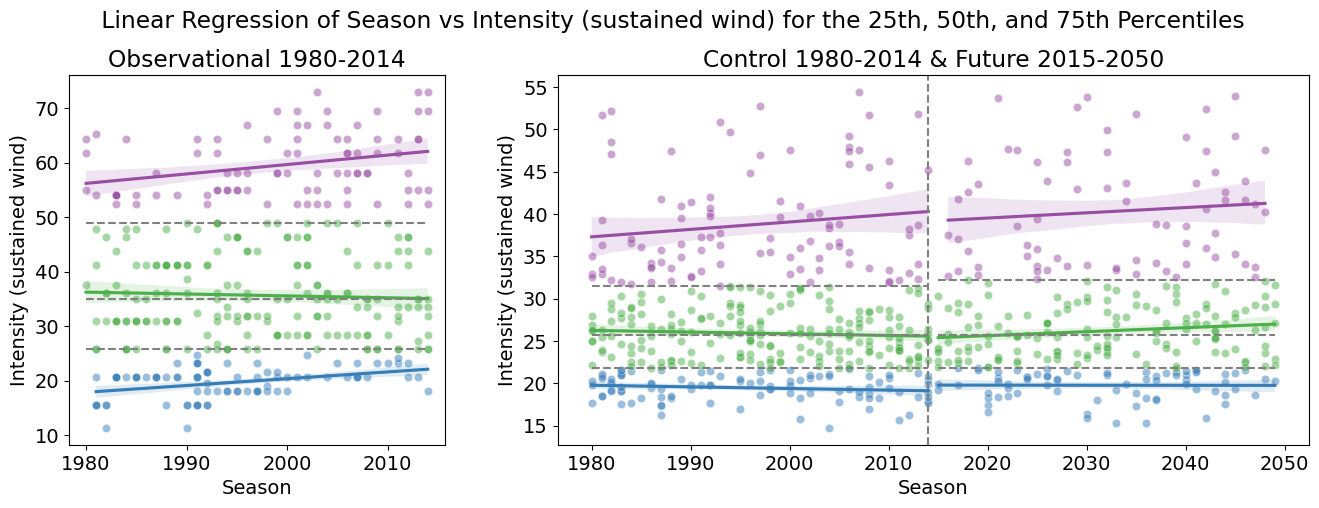

In [88]:
plot_running_means("season","vmax", obs_df, control_df, future_df, "Season", "Intensity (sustained wind)")

 Pearson correlation coefficient: 0.3814
 Linear regression p-value: 0.0003

 Pearson correlation coefficient: 0.0142
 Linear regression p-value: 0.8926

 Pearson correlation coefficient: 0.096
 Linear regression p-value: 0.4397

 Pearson correlation coefficient: 0.0955
 Linear regression p-value: 0.1897

 Pearson correlation coefficient: 0.0403
 Linear regression p-value: 0.5591

 Pearson correlation coefficient: -0.0091
 Linear regression p-value: 0.9093

 Pearson correlation coefficient: 0.0247
 Linear regression p-value: 0.8246

 Pearson correlation coefficient: 0.0435
 Linear regression p-value: 0.682

 Pearson correlation coefficient: 0.2286
 Linear regression p-value: 0.0648



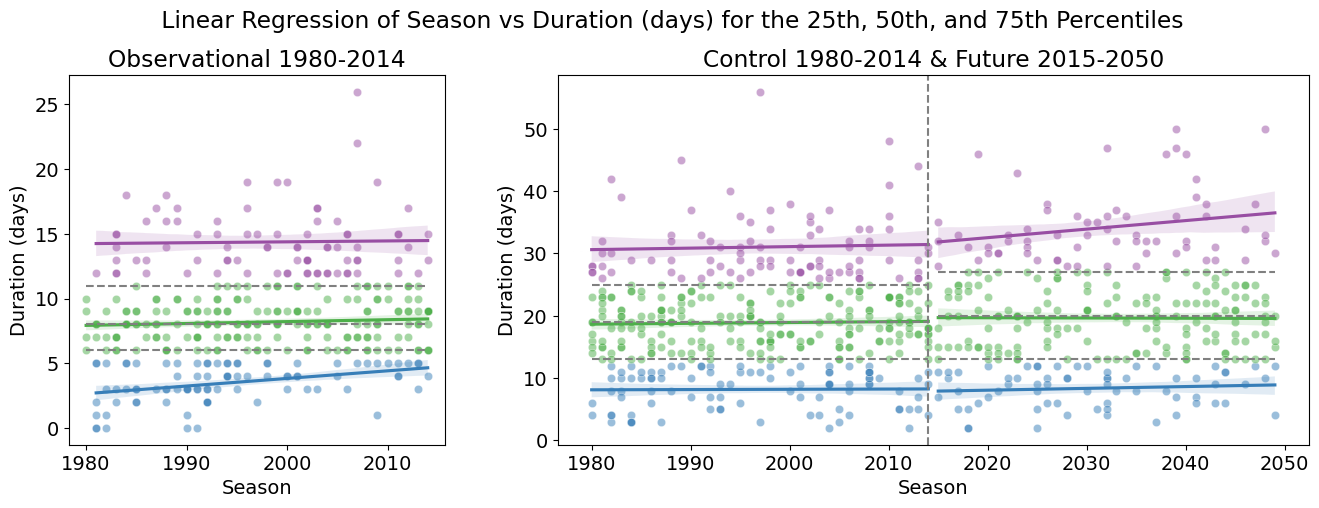

In [89]:
plot_running_means("season","duration", obs_df, control_df, future_df, "Season", "Duration (days)")

In [90]:
def plot_distribution(x_col, obs_data, control_data, future_data, bin):
    # Create a figure with 3 subplots
    fig, axes = plt.subplots(1,2,figsize=(16, 5), gridspec_kw={'width_ratios': [1, 1]})

    # Create a KDE plot for each dataset in a different subplot
    sns.histplot(data=obs_data, x="frequency",binwidth= bin, kde=True, ax=axes[0])
    sns.histplot(data=control_data, x="frequency",binwidth= bin, kde=True, ax=axes[1])
    sns.histplot(data=future_data, x="frequency",binwidth= bin, kde=True, ax=axes[1])

    # Set the titles for each subplot
    axes[0].set_title("Observational 1980-2014")
    axes[1].set_title("Control 1980-2014 & Future 2015-2050")

    # Add a vertical line to show the edge of the second plot
    axes[1].axvline(x=obs_data[x_col].max(), linestyle='--', color='gray')

   
    # Add a title to the entire figure
    #fig.suptitle("Distribution of {}".format(x_col))

    # Adjust the layout to avoid overlapping titles
    plt.subplots_adjust(top=0.85, hspace=0.2, right=0.9)

    # Set the same limits for the x-axis in all subplots
    xmin = min(obs_data[x_col].min(), control_data[x_col].min(), future_data[x_col].min())
    xmax = max(obs_data[x_col].max(), control_data[x_col].max(), future_data[x_col].max())
    for ax in axes:
        ax.set_xlim([xmin, xmax])

    ymin = min([ax.get_ylim()[0] for ax in axes])
    ymax = max([ax.get_ylim()[1] for ax in axes])
    for ax in axes:
        ax.set_ylim([ymin, ymax])

    plt.rcParams.update({'font.size': 14})

    plt.savefig('D:\Masters_Thesis\Report_Writing\\figures\distribution_{}_{}_all_basin.pdf'.format(x_label, y_label),bbox_inches='tight') 

    # Display the plot
    plt.show()

In [129]:

import scipy.stats as stats

def plot_storms_distribution(x_col, obs_data, control_data, future_data, x_label,binwidth=1, color=None):
    # Create a figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    deep_palette = sns.color_palette()
    obs_color = deep_palette[0]
    control_color = deep_palette[2]
    future_color = deep_palette[1]
    line_color = deep_palette[7]
    

    # Create a KDE plot for each dataset in a different subplot
    sns.histplot(data=obs_data, x=x_col, binwidth=binwidth, kde=True, ax=axes[0],color=obs_color)
    sns.histplot(data=control_data, x=x_col, binwidth=binwidth, kde=True, ax=axes[1],color=control_color)
    sns.histplot(data=future_data, x=x_col, binwidth=binwidth, kde=True, ax=axes[2],color=future_color)

    # Set the titles for each subplot
    axes[0].set_title("Observations \n 1980-2014")
    axes[1].set_title("Control - 1950s RF \n 1980-2014")
    axes[2].set_title("Future - SSP5-8.5  RF \n 2015-2050")

    # Set a common x-axis label for all subplots
    # fig.text(0.5, 0.04, 'frequency', ha='center')

    # Add a title to the entire figure
    #fig.suptitle("Distribution of {}".format(x_label))

    # Adjust the layout to avoid overlapping titles
    plt.subplots_adjust(top=0.85, wspace=0.2)

    # Set the same limits for the x-axis in all subplots
    xmin = min(obs_data[x_col].min(), control_data[x_col].min(), future_data[x_col].min())
    xmax = max(obs_data[x_col].max(), control_data[x_col].max(), future_data[x_col].max())
    for ax in axes:
        ax.set_xlim([xmin, xmax])

    ymin = min([ax.get_ylim()[0] for ax in axes])
    ymax = max([ax.get_ylim()[1] for ax in axes])
    for ax in axes:
        ax.set_ylim([ymin, ymax])

    # Set the x and y axis labels
    axes[0].set_xlabel(x_label)
    axes[1].set_xlabel(x_label)
    axes[2].set_xlabel(x_label)
    

    # Perform the Kruskal-Wallis test and add to the plot
    _, p_value = stats.kruskal(obs_data[x_col], control_data[x_col], future_data[x_col])
    #print("Kruskal-Wallis p-value:", p_value)
    #p_value_str = "Kruskal-Wallis p-value: {}".format(p_value) 
    #axes[1].annotate(p_value_str, xy=(0.5, -0.2), xycoords='axes fraction', ha='center')

    plt.rcParams.update({'font.size': 14})

    # Save figure
    #plt.savefig('D:\Masters_Thesis\Report_Writing\\figures\distribution_{}._all_basin.pdf'.format(x_label),bbox_inches='tight')
    plt.savefig(r'D:\\Masters_Thesis\\Report_Writing\\figures\distribution_{}._all_basin.pdf'.format(x_label.replace('/', '_')), bbox_inches='tight')

    print(p_value)

    # Display the plot
    plt.show()



2.660617604948887e-05


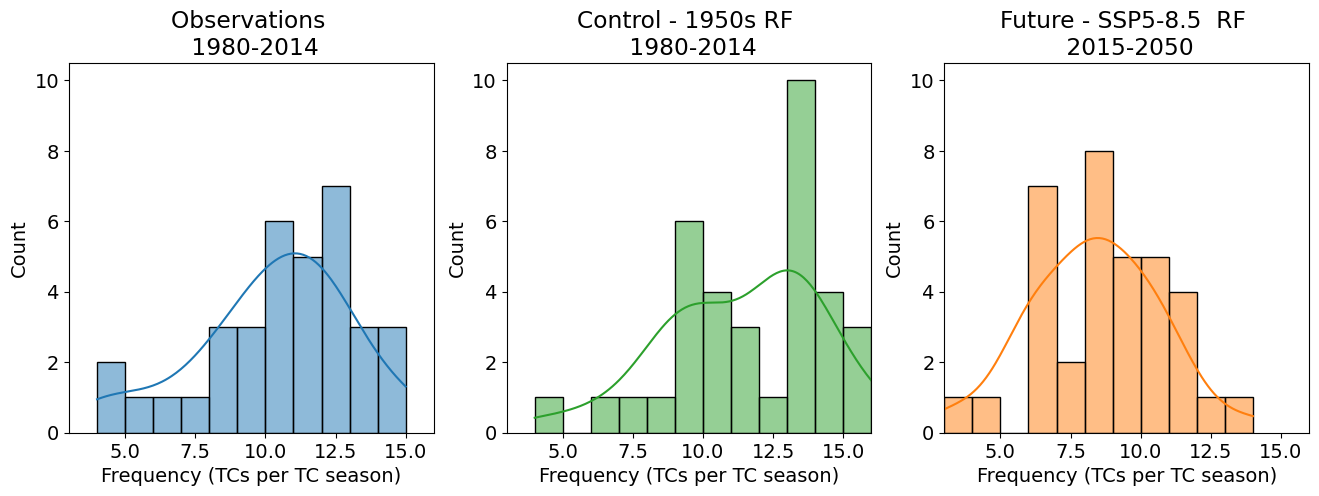

In [130]:
plot_storms_distribution("frequency", obs_storms_per_season, control_storms_per_season, future_storms_per_season, "Frequency (TCs per TC season)", binwidth=1)


8.95807543314369e-84


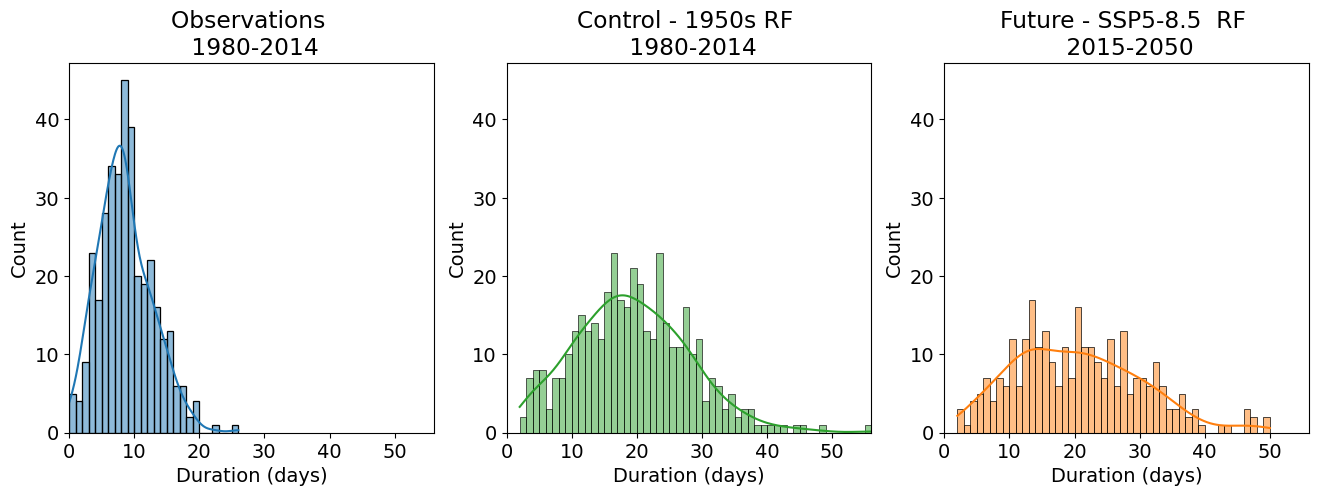

In [131]:
plot_storms_distribution("duration", obs_df, control_df, future_df, "Duration (days)" ,binwidth=1)

2.6578879053535994e-22


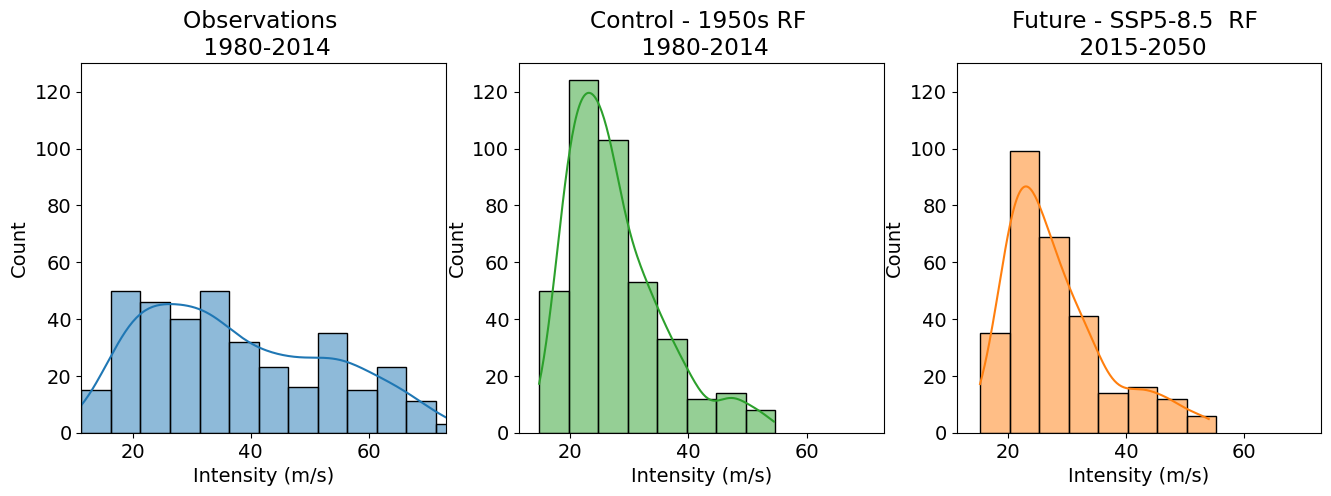

In [132]:
plot_storms_distribution("vmax", obs_df, control_df, future_df,"Intensity (m/s)", binwidth=5)


In [133]:
def plot_storms_distribution_35(x_col, obs_data, control_data, future_data, x_label,binwidth=1):
    # Filter the data based on the criteria
    obs_data_filtered = obs_data[obs_data['vmax'] >= 35]
    control_data_filtered = control_data[control_data['vmax'] >= 35]
    future_data_filtered = future_data[future_data['vmax'] >= 35]

    # Create a figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    deep_palette = sns.color_palette()
    obs_color = deep_palette[0]
    control_color = deep_palette[2]
    future_color = deep_palette[1]
    line_color = deep_palette[7]
    

    # Create a KDE plot for each dataset in a different subplot
    sns.histplot(data=obs_data_filtered, x=x_col, binwidth=binwidth, kde=True, ax=axes[0],color=obs_color)
    sns.histplot(data=control_data_filtered, x=x_col, binwidth=binwidth, kde=True, ax=axes[1],color=control_color)
    sns.histplot(data=future_data_filtered, x=x_col, binwidth=binwidth, kde=True, ax=axes[2],color=future_color)

    # Set the titles for each subplot
    axes[0].set_title("Observations \n 1980-2014")
    axes[1].set_title("Control - 1950s RF \n 1980-2014")
    axes[2].set_title("Future - SSP5-8.5  RF \n 2015-2050")

    # Set a common x-axis label for all subplots
    # fig.text(0.5, 0.04, 'frequency', ha='center')

    # Add a title to the entire figure
    #fig.suptitle("Distribution of {}".format(x_label))

    # Adjust the layout to avoid overlapping titles
    plt.subplots_adjust(top=0.85, wspace=0.2)

    # Set the same limits for the x-axis in all subplots
    xmin = min(obs_data_filtered[x_col].min(), control_data_filtered[x_col].min(), future_data_filtered[x_col].min())
    xmax = max(obs_data_filtered[x_col].max(), control_data_filtered[x_col].max(), future_data_filtered[x_col].max())
    for ax in axes:
        ax.set_xlim([xmin, xmax])

    ymin = min([ax.get_ylim()[0] for ax in axes])
    ymax = max([ax.get_ylim()[1] for ax in axes])
    for ax in axes:
        ax.set_ylim([ymin, ymax])

    # Set the x and y axis labels
    axes[0].set_xlabel(x_label)
    axes[1].set_xlabel(x_label)
    axes[2].set_xlabel(x_label)
    

    # Perform the Kruskal-Wallis test and add to the plot
    _, p_value = stats.kruskal(obs_data_filtered[x_col], control_data_filtered[x_col], future_data_filtered[x_col])
    #print("Kruskal-Wallis p-value:", p_value)
    #p_value_str = "Kruskal-Wallis p-value: {}".format(p_value) 
    #axes[1].annotate(p_value_str, xy=(0.5, -0.2), xycoords='axes fraction', ha='center')

    plt.rcParams.update({'font.size': 14})

    # Save figure
    #plt.savefig('D:\Masters_Thesis\Report_Writing\\figures\distribution_35_{}_all_basin.pdf'.format(x_label),bbox_inches='tight')
    plt.savefig(r'D:\\Masters_Thesis\\Report_Writing\\figures\distribution_35_{}._all_basin.pdf'.format(x_label.replace('/', '_')), bbox_inches='tight')

    print(p_value)

    # Display the plot
    plt.show()

7.5912017403804925e-31


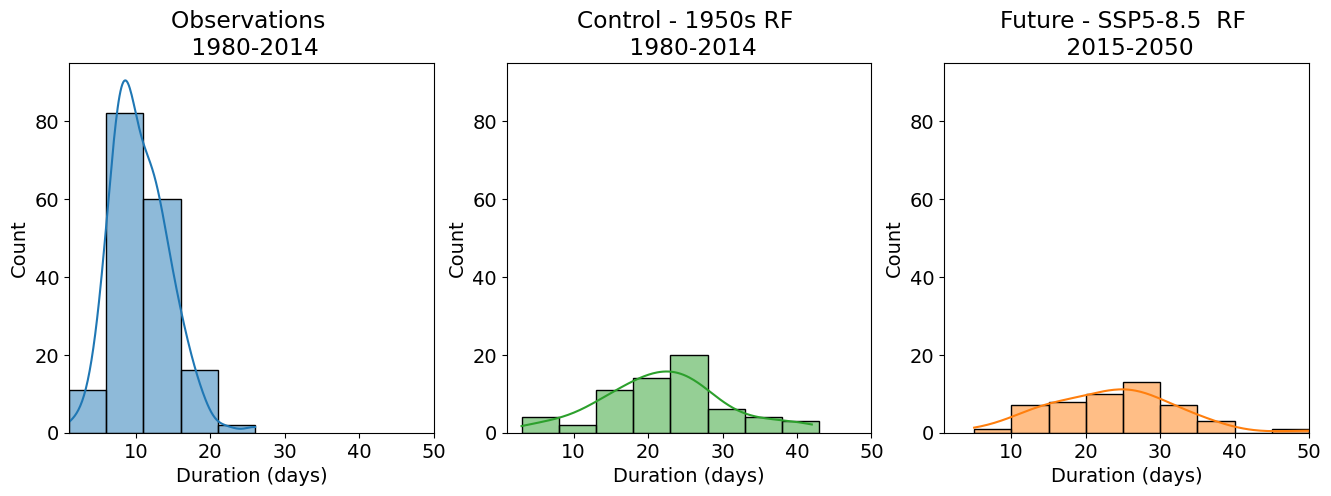

In [134]:
plot_storms_distribution_35("duration", obs_df, control_df, future_df,"Duration (days)", binwidth=5)